In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
import os
import re
import collections
from collections import Counter, defaultdict
from itertools import chain, combinations
import time
import json


In [3]:
from cdlib import algorithms
import networkx as nx
import matplotlib.pyplot as plt

# installation easiest via pip:
# pip install netgraph
from netgraph import Graph
from community import community_louvain

In [4]:
ls

README.md
WOS Cleaning and Cofunder Data Processing.ipynb
cofunder_researchArea_links.json
cofunder_wosCategories_links.json
funderSubjStats.json
funderSubjStats.p
funder_subj_stats/
graphs/
green-file-text.html
plotting.R
researchAreas.json
researchAreas_funder_associations.csv
researchAreas_funder_associations.xlsm
researchAreas_funder_associations.xlsx
topCofunders.json
top_cofunder_frequencies.csv
top_cofunder_frequencies_validated_06182021.xlsx
validation_round_two.csv
wosCategories.json
wosCategory_funder_associations.csv
wos_funders_2010to2021.xlsx


# Data Loading and Cleaning

In [4]:
df = pd.read_excel("wos_funders_2010to2021.xlsx")

In [5]:
df.head()

Unnamed: 0 Publication Type  \
0           0                J   
1           1                J   
2           2                J   
3           3                J   
4           4                J   

                                             Authors Book Authors  \
0               He, QW; Borgonovi, F; Paccagnella, M          NaN   
1                             Misoska, AT; Loader, R          NaN   
2  Chin, ET; Leidner, D; Ryckman, T; Liu, YRE; Pr...          NaN   
3               Swencionis, JK; Pouget, ER; Goff, PA          NaN   
4  Greene, SK; Peterson, ER; Balan, D; Jones, L; ...          NaN   

  Book Editors Book Group Authors  \
0          NaN                NaN   
1          NaN                NaN   
2          NaN                NaN   
3          NaN                NaN   
4          NaN                NaN   

                                   Author Full Names Book Author Full Names  \
0  He, Qiwei; Borgonovi, Francesca; Paccagnella, ...                    NaN   
1             Misoska, Ana Tomovska; Loader, Rebecca                    NaN   
2  Chin, Elizabeth T.; Leidner, David; Ryckman, T...                    NaN   
3  Swencionis, Jillian K.; Pouget, Enrique R.; Go...                    NaN   
4  Greene, Sharon K.; Peterson, Eric R.; Balan, D...                    NaN   

  Group Authors                                      Article Title  ...  \
0           NaN  Leveraging process data to assess adults' prob...  ...   
1           NaN  The role of school-based contact in reducing s...  ...   
2           NaN  Covid-19 Vaccine Acceptance in California Stat...  ...   
3           NaN  Supporting social hierarchy is associated with...  ...   
4           NaN  Detecting COVID-19 Clusters at High Spatiotemp...  ...   

  IDS Number   UT (Unique WOS ID)   Pubmed Id    Open Access Designations  \
0      QT0TV  WOS:000626306200014         NaN                         NaN   
1      SG2DR  WOS:000653253800001         NaN                         NaN   
2      SB2FY  WOS:000649816900001  33979505.0     Bronze, Green Published   
3      RX4ME  WOS:000647198300019         NaN                         NaN   
4      SB6SQ  WOS:000650121700033  33900181.0  DOAJ Gold, Green Published   

  Highly Cited Status Hot Paper Status Date of Export Unnamed: 67  \
0                 NaN              NaN     2021-06-14         NaN   
1                 NaN              NaN     2021-06-14         NaN   
2                 NaN              NaN     2021-06-14         NaN   
3                 NaN              NaN     2021-06-14         NaN   
4                 NaN              NaN     2021-06-14         NaN   

  funder_dataset        oa_summary  
0            osf             NO_OA  
1            osf  PUBLISHER_HOSTED  
2            osf     AUTHOR_HOSTED  
3            osf             NO_OA  
4            osf             NO_OA  

[5 rows x 71 columns]

In [6]:
## the target funders that were used to query WoS are given as a column previously created...
funders = list(set(df.funder_dataset))
funders

['packard', 'hewlett', 'rwj', 'mellon', 'gates', 'ford', 'osf']

In [7]:
# remove rows that got thrown into the mellon query based on the Robert King Mellon Foundation
# remove rows that include carnegie or paul mellon without andrew or a.w.
df["remove_rows"] = [1 if (dataset=="mellon" and any(ele in funderString.lower() for ele in ["r. k.","r.k.","king","richard k"])) else 0 for (dataset,funderString) in zip(df['funder_dataset'],df['Funding Orgs']) ]
df["remove_rows"] = [1 if (dataset=="mellon" and any(ele in funderString.lower() for ele in ["carnegie","paul"]) and not(any(ele in funderString.lower() for ele in ["a.w.","andrew"]))) else cur_val for (dataset,funderString,cur_val) in zip(df['funder_dataset'],df['Funding Orgs'],df['remove_rows'])]

In [8]:
df['Funding Orgs'] = [x.replace("AMP;","&") for x in df['Funding Orgs']]

In [9]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [10]:
sum(df.remove_rows)

266

In [11]:
df = df[df.remove_rows != 1]

In [12]:
## extract grant number strings
df['grant_nums'] = [re.findall(r'\[[a-zA-Z0-9\-\.\s\:\,\/\\]*\]',str(x)) for x in df['Funding Orgs']]
## start a clean cofunder column without the grant nums
df['cofunder_clean'] = df['Funding Orgs']
for index,row in df.iterrows():
    if len(row['grant_nums']) > 0:
        for gn in row['grant_nums']:
            df.at[index,'cofunder_clean'] = df.at[index,'cofunder_clean'].replace(gn,"")

# TO DO: examine how many instances of grant numbers are indicated
# how many cofunders per grant record
## can we vet these any further, or do any linking?

In [13]:
df["cofunders_list"] = [x.split(";") for x in df['cofunder_clean']]

In [14]:
df['Author_Full_Names_list'] = [str(x).split(";") if str(x) != "nan" else [] for x in df['Author Full Names'] ]
df["Group_Author_list"] = [str(x).split(";") if str(x) != "nan" else [] for x in df['Group Authors']]
df["Document_Type_list"] = [str(x).split(";") if str(x) != "nan" else [] for x in df["Document Type"]]

In [15]:
## make a cofunder dictionary for each target funder that lists its cofunders
## this is used for manual cleanup and replacements of top funders used below.. 
def make_cofunder_dict(df,funder_list_col):
    cofunderDict = {}
    for f in funders:
        d = df[df.funder_dataset == f]
        cof_list = list(chain.from_iterable(d[funder_list_col]))
        cof_list = [x.strip() for x in cof_list]
        cofunderDict[f] = collections.Counter(cof_list)
    return(cofunderDict)

In [16]:
cofunderDict = make_cofunder_dict(df,'cofunders_list')

In [17]:
#cofunderDict['osf']

In [18]:
## number of unique keys
for k,v in cofunderDict.items():
    print(k,len(list(set(v))))

packard 13728
hewlett 2005
rwj 12227
mellon 5211
gates 31527
ford 4574
osf 2466


## Data validation setup

In [19]:
## explored using text distance to measure similarity between strings
## so as to consolidate closely related instances like "Ford Foundation" and "Henry Ford Foundation"
## ultimately, the algorithm takes a long time to compute between tokens and the recurrent words like
## 'science' 'technology' 'foundation' 'research' skew the results too far to make it useful

In [20]:
import textdistance

In [21]:
textdistance.ratcliff_obershelp("merry christmas mer","mer")

0.2727272727272727

In [22]:
len("mer")/len("merry christmas mer")

0.15789473684210525

In [23]:
## get the X most frequent cofunders, and add an option for measuring substring similarity with other entries
## 

def get_freq_cofunders_similarities(df,cofunderDict,funder_list_col,n_most,get_sims):
    cofSim ={}
    topCof = {}

    start = time.time()
    for f in funders:
        cofunders = [(x,y) for (x,y) in cofunderDict[f].most_common(n_most)]
        topCof[f] = cofunders
        if get_sims is True:
            d = df[df.funder_dataset == f]
            cof_list = list(chain.from_iterable(d[funder_list_col]))
            cof_list = [x.strip() for x in cof_list]
            cofSim[f] = {}
            for (x,y) in cofunders:
                similarities = []
                t1 = x.replace("Foundation","").replace("National","").strip()
                for cof in cof_list:
                    t2 = cof.replace("Foundation","").replace("National","").strip()
                    ## if there is at least some common element
                    if bool(set(t1.split(" ")) & set(t2.split(" "))):
                        similarities.append(tuple((tuple((x,cof)),textdistance.ratcliff_obershelp(t1,t2))))
                similarities = [(strings,measure) for (strings,measure) in similarities if measure > 0.32]   
                #similarities = [tuple((tuple((x,y)),textdistance.ratcliff_obershelp(x.replace("Foundation",""),y.replace("Foundation","")))) for y in cof_list  ]
                #similarities = [(strings,measure) for (strings,measure) in similarities if measure > 0.32]
                cofSim[f][x] = collections.Counter(similarities)
        print(time.time() - start)
    return(cofSim,topCof)
        
        
        

In [24]:
cofSim,topCof = get_freq_cofunders_similarities(df,cofunderDict,'cofunders_list',250,False)

0.0029058456420898438
0.0038428306579589844
0.006455659866333008
0.008075714111328125
0.01500391960144043
0.016890764236450195
0.017857789993286133


In [25]:
cofSim

{}

In [26]:
topCof['osf']

[('Open Society Foundations', 237),
 ('Open Society Foundation', 112),
 ('Open Society Institute', 74),
 ('NIHUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USA',
  70),
 ('National Science FoundationNational Science Foundation (NSF)', 69),
 ('Paul and Daisy Soros Fellowship', 68),
 ('Paul and Daisy Soros Fellowship for New Americans', 65),
 ('NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCESUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USANIH National Institute of General Medical Sciences (NIGMS)  Funding Source: NIH RePORTER',
  65),
 ('NATIONAL INSTITUTE ON DRUG ABUSEUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USANIH National Institute on Drug Abuse (NIDA)European Commission  Funding Source: NIH RePORTER',
  53),
 ('NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASESUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - US

In [27]:
## output a dataframe of the top cofunders for each target funder
## use this dataframe to resolve differences manually in Excel and read this back in later..
def get_cof_freq_df(topCofDict):
    cofDf = pd.DataFrame()
    funder_dataset = []
    entry = []
    val = []
    for k,v in topCofDict.items():
        for funder,count in v:
            funder_dataset.append(k)
            entry.append(funder)
            val.append(count)
            
    cofDf["dataset"] = funder_dataset
    cofDf["funder_value"] = entry
    cofDf["frequency"] = val
    return(cofDf)

In [28]:
cofDf = get_cof_freq_df(topCof)

In [29]:
cofDf

dataset                                       funder_value  frequency
0     packard  David and Lucile Packard FoundationThe David &...       3620
1     packard               NSFNational Science Foundation (NSF)       1923
2     packard  Packard FoundationThe David & Lucile Packard F...       1488
3     packard  National Science FoundationNational Science Fo...       1476
4     packard  NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES...        687
...       ...                                                ...        ...
1745      osf                              Livestrong Foundation          3
1746      osf  Open Society Foundation's International Pallia...          3
1747      osf  Eunice Kennedy Shriver National Institute of C...          3
1748      osf                              LIVESTRONG Foundation          3
1749      osf           Boehringer IngelheimBoehringer Ingelheim          3

[1750 rows x 3 columns]

In [30]:
#cofDf.to_csv("top_cofunder_frequencies.csv")

In [31]:
cofDf.head(15)

dataset                                       funder_value  frequency
0   packard  David and Lucile Packard FoundationThe David &...       3620
1   packard               NSFNational Science Foundation (NSF)       1923
2   packard  Packard FoundationThe David & Lucile Packard F...       1488
3   packard  National Science FoundationNational Science Fo...       1476
4   packard  NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES...        687
5   packard  NASANational Aeronautics & Space Administratio...        647
6   packard  NIHUnited States Department of Health & Human ...        579
7   packard  Alfred P. Sloan FoundationAlfred P. Sloan Foun...        552
8   packard                                                           515
9   packard  David and Lucille Packard FoundationThe David ...        496
10  packard  National Institutes of HealthUnited States Dep...        452
11  packard  Gordon and Betty Moore FoundationGordon and Be...        426
12  packard  Packard FellowshipThe David & Lucile Packard F...        373
13  packard  Direct For Mathematical & Physical ScienNation...        353
14  packard    Lucile Packard Foundation for Children's Health        254

In [32]:
## some contain a weird encoding of the ampress and... examining that here.. 
df[df['Funding Orgs'].str.contains("AMP")]['Funding Orgs']

1857     Leona M. and Harry B. Helmsley Charitable Trus...
4293     Abbott FundAbbott Laboratories; CDCCentre Nati...
4834     Adolescent Risk Communication Institute's Codi...
11329    DOE YIP; David and Lucile Packard FoundationTh...
11595    California State University Council on Ocean A...
11933    David and Lucile Packard FoundationThe David &...
12097    David and Lucille Packard FoundationThe David ...
12334    David and Lucile Packard FoundationThe David &...
12374    NSFNational Science Foundation (NSF) [ECS-0335...
14974    National Science FoundationNational Science Fo...
16504    Kavli Foundation; Danish National Research Fou...
17720    PAPIIT, UNAMPrograma de Apoyo a Proyectos de I...
18703    Packard Foundation, NSF [AST0847563]; PAPIIT-U...
18764    Packard FoundationThe David & Lucile Packard F...
20664    Child Health and Mortality Prevention Surveill...
22256    European Union [Marie Curie International Outg...
22628    International AIDS Vaccine Initiative (IAVI) f.

### Test for Repeated Funder Strings and clean them

In [33]:
## some strings contain repeated instances of the funder's name
## use this to detect if there is such a repetition, to help manual validation steps
def principal_period(s):
    i = (s+s).find(s, 1, -1)
    return None if i == -1 else s[:i]


In [34]:
## read from remaining lines on validation sheet
#df = pd.read_clipboard()

In [35]:
#df

In [36]:
#df['dup_rep'] = [principal_period(str(x)) for x in df['funder_value']]

In [37]:
#df.to_clipboard()

## Merge validated entries back in to a validated cofunder column

In [38]:
valDf = pd.read_excel("top_cofunder_frequencies_validated_06182021.xlsx",sheet_name="top_cofunder_frequencies")

In [39]:
valDf

Unnamed: 0  dataset                                       funder_value  \
0              0    gates  Bill and Melinda Gates FoundationBill & Melind...   
1              1    gates  Bill & Melinda Gates FoundationBill & Melinda ...   
2              2    gates  NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS D...   
3              3    gates  Bill & Melinda Gates FoundationBill & Melinda ...   
4              4    gates  NIHUnited States Department of Health & Human ...   
...          ...      ...                                                ...   
1745        1494      osf  Michael Smith Foundation for Health ResearchMi...   
1746        1495  packard               Wisconsin Alumni Research Foundation   
1747        1498  hewlett                   Wolf Creek Charitable Foundation   
1748        1499      osf           Boehringer IngelheimBoehringer Ingelheim   
1749         385      rwj  Agency for Healthcare Research and Quality (AH...   

      frequency                                   validated_funder round  
0          9873                  Bill and Melinda Gates Foundation   NaN  
1          5548                  Bill and Melinda Gates Foundation   NaN  
2          3625  United States National Institutes of Health (NIH)   NaN  
3          2579           Bill and Melinda Gates Foundation; CGIAR   NaN  
4          1538  United States National Institutes of Health (NIH)   NaN  
...         ...                                                ...   ...  
1745          3       Michael Smith Foundation for Health Research   NaN  
1746         25               Wisconsin Alumni Research Foundation   NaN  
1747          4                   Wolf Creek Charitable Foundation   NaN  
1748          3                               Boehringer Ingelheim   NaN  
1749         44  United States Department of Health and Human S...   NaN  

[1750 rows x 6 columns]

In [40]:
df

Unnamed: 0 Publication Type  \
0               0                J   
1               1                J   
2               2                J   
3               3                J   
4               4                J   
...           ...              ...   
50304         495                J   
50305         496                J   
50306         497                J   
50307         498                J   
50308         499                J   

                                                 Authors Book Authors  \
0                   He, QW; Borgonovi, F; Paccagnella, M          NaN   
1                                 Misoska, AT; Loader, R          NaN   
2      Chin, ET; Leidner, D; Ryckman, T; Liu, YRE; Pr...          NaN   
3                   Swencionis, JK; Pouget, ER; Goff, PA          NaN   
4      Greene, SK; Peterson, ER; Balan, D; Jones, L; ...          NaN   
...                                                  ...          ...   
50304                                          Grine, FE          NaN   
50305                            Colozza, D; Avendano, M          NaN   
50306  Thomas, MD; Michaels, EK; Reeves, AN; Okoye, U...          NaN   
50307                     Tanner, JC; Swanger, E; Zuk, M          NaN   
50308  Hotard, M; Lawrence, D; Laitin, DD; Hainmuelle...          NaN   

      Book Editors Book Group Authors  \
0              NaN                NaN   
1              NaN                NaN   
2              NaN                NaN   
3              NaN                NaN   
4              NaN                NaN   
...            ...                ...   
50304          NaN                NaN   
50305          NaN                NaN   
50306          NaN                NaN   
50307          NaN                NaN   
50308          NaN                NaN   

                                       Author Full Names  \
0      He, Qiwei; Borgonovi, Francesca; Paccagnella, ...   
1                 Misoska, Ana Tomovska; Loader, Rebecca   
2      Chin, Elizabeth T.; Leidner, David; Ryckman, T...   
3      Swencionis, Jillian K.; Pouget, Enrique R.; Go...   
4      Greene, Sharon K.; Peterson, Eric R.; Balan, D...   
...                                                  ...   
50304                                Grine, Frederick E.   
50305                 Colozza, David; Avendano, Mauricio   
50306  Thomas, Marilyn D.; Michaels, Elizabeth K.; Re...   
50307  Tanner, Jessie C.; Swanger, Elizabeth; Zuk, Ma...   
50308  Hotard, Michael; Lawrence, Duncan; Laitin, Dav...   

      Book Author Full Names Group Authors  \
0                        NaN           NaN   
1                        NaN           NaN   
2                        NaN           NaN   
3                        NaN           NaN   
4                        NaN           NaN   
...                      ...           ...   
50304                    NaN           NaN   
50305                    NaN           NaN   
50306                    NaN           NaN   
50307                    NaN           NaN   
50308                    NaN           NaN   

                                           Article Title  ... Unnamed: 67  \
0      Leveraging process data to assess adults' prob...  ...         NaN   
1      The role of school-based contact in reducing s...  ...         NaN   
2      Covid-19 Vaccine Acceptance in California Stat...  ...         NaN   
3      Supporting social hierarchy is associated with...  ...         NaN   
4      Detecting COVID-19 Clusters at High Spatiotemp...  ...         NaN   
...                                                  ...  ...         ...   
50304  The alpha taxonomy of Australopithecus at Ster...  ...         NaN   
50305  Urbanisation, dietary change and traditional f...  ...         NaN   
50306  Differential associations between everyday ver...  ...         NaN   
50307  Sexual signal loss in field crickets maintaine...  ...         NaN   
50308  A low-cost information nudge increases citizen...  .

In [41]:
## this funciton will merge a validated list with the main dataframe to make a validated cofunder list column
## "full_merge" option accounts for second or third iterations of validation where the entire sheet was not completed

def merge_validated_entries(valDf,df,cofunders_list,validated_cof_list,full_merge=True):
    
    if full_merge is False:
        valDf = valDf[~valDf.validated_funder.isna() ]
    valDict = dict()
    for index,row in valDf.iterrows():
        valDict[str(row['funder_value']).strip()] = str(row['validated_funder']).strip()
        
    df[validated_cof_list] = ""
    for index,row in df.iterrows():
        validated_list = []
        for funder in row[cofunders_list]:
            validated_list.append(valDict.get(funder.strip(),funder).strip())
        df.at[index,validated_cof_list] = list(set(validated_list))
    return(valDict,df)

In [42]:
valDict,df = merge_validated_entries(valDf,df,'cofunders_list','validated_cof_list',full_merge=True)

In [43]:
## unvalidated cofunder list example
df['cofunders_list'][4]

['Public Health Emergency Preparedness Cooperative Agreement - Centers for Disease Control and Prevention (CDC)United States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA ',
 ' SaTScan Enhancements Project',
 ' CDC FoundationUnited States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA',
 ' CDC ELC CARES ',
 ' Alfred P. Sloan FoundationAlfred P. Sloan Foundation',
 ' Open Society Foundations']

In [44]:
## validated cofunder list example
df['validated_cof_list'][4]

['CDC FoundationUnited States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA',
 'CDC ELC CARES',
 'Open Society Foundations',
 'SaTScan Enhancements Project',
 'Public Health Emergency Preparedness Cooperative Agreement - Centers for Disease Control and Prevention (CDC)United States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA',
 'Alfred P. Sloan Foundation']

In [45]:
##m checking to make sure the dict works...
valDict['Alfred P. Sloan FoundationAlfred P. Sloan Foundation']

'Alfred P. Sloan Foundation'

In [46]:
## checking the dict...
for f in df['cofunders_list'][4]:
    print("\n",f,"\n\n")
    print(valDict.get(f.strip(),None))


 Public Health Emergency Preparedness Cooperative Agreement - Centers for Disease Control and Prevention (CDC)United States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA  


None

  SaTScan Enhancements Project 


None

  CDC FoundationUnited States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA 


None

  CDC ELC CARES  


None

  Alfred P. Sloan FoundationAlfred P. Sloan Foundation 


Alfred P. Sloan Foundation

  Open Society Foundations 


Open Society Foundations


In [47]:
valDict.keys()

dict_keys(['Bill and Melinda Gates FoundationBill & Melinda Gates Foundation', 'Bill & Melinda Gates FoundationBill & Melinda Gates Foundation', 'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASESUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USANIH National Institute of Allergy & Infectious Diseases (NIAID)  Funding Source: NIH RePORTER', 'Bill & Melinda Gates FoundationBill & Melinda Gates FoundationCGIAR', 'NIHUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USA', 'Wellcome TrustWellcome TrustEuropean Commission', 'National Institutes of HealthUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USA', 'Medical Research CouncilUK Research & Innovation (UKRI)Medical Research Council UK (MRC)European Commission  Funding Source: researchfish', 'NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCESUnited States Department of Health & Human ServicesNational Institutes of Healt

In [48]:
## feed the validated cofunder list column back into the cofounder dictionary funciton 
## to start a second iteration of validation

validatedCofDict = make_cofunder_dict(df,'validated_cof_list')

In [49]:
validatedCofDict

{'packard': Counter({'David and Lucile Packard Foundation': 7035,
          'United States Centers for Disease Control and Prevention (CDC)': 9,
          'William and Flora Hewlett Foundation': 89,
          'Caltech-JPL postdoctoral fellowship': 1,
          'NASA NPP Senior Fellowship': 1,
          'S-Mode project': 1,
          'United States National Aeronautics & Space Administration (NASA)': 789,
          'SWOT': 1,
          'Physical Oceanography (PO) and Modeling, Analysis, and Prediction (MAP) Programs': 1,
          'David and Lucile Packard Foundation Special Projects Grant': 4,
          'Spark Program in Translational Research': 5,
          'Hartwell Foundation': 24,
          'Wu Tsai Neurosciences Institute Neuroscience: Translate Program': 6,
          'Peter Sullivan': 1,
          "Stanford's Institute of Human Centered Artificial Intelligence": 4,
          'Weston Havens Foundation': 7,
          "Spectrum Pilot Program, Stanford's Precision Health and Integrat

In [50]:
## get a dataframe of the 250 most frequent cofunders after the first validation, validate again...
cofSim,topCof_validated = get_freq_cofunders_similarities(df,validatedCofDict,'validated_cof_list',250,False)

0.002930164337158203
0.003854990005493164
0.006665945053100586
0.008069992065429688
0.01442098617553711
0.015575885772705078
0.01628899574279785


In [51]:
topCof_validated['mellon']

[('Andrew W. Mellon Foundation', 2278),
 ('United States National Science Foundation (NSF)', 837),
 ('South African National Research Foundation', 250),
 ('MacArthur Foundation', 178),
 ('United States National Institutes of Health (NIH)', 162),
 ('Smithsonian Institution', 154),
 ('Gordon and Betty Moore Foundation', 95),
 ('David and Lucile Packard Foundation', 88),
 ('W.M. Keck Foundation', 73),
 ('Avatar Alliance Foundation', 60),
 ('University of the Witwatersrand', 57),
 ('Grantham Foundation for the Protection of the Environment', 54),
 ('Margaret A. Cargill Foundation', 52),
 ('Small World Institute Fund', 51),
 ('National Geographic Society', 51),
 ('Celera Foundation', 50),
 ('UK Research and Innovation (UKRI)', 47),
 ('Wenner-Gren Foundation', 44),
 ('Social Sciences Research Council (SSRC)', 44),
 ('Government of South Africa', 42),
 ('United States National Aeronautics & Space Administration (NASA)', 36),
 ('American Council of Learned Societies', 36),
 ('Wellcome Trust', 

In [52]:
### to do: parse the strings that still have a semicolon in them after validation
## so that these strings are counted towards the accurate funders

onceValidated_cofDf = get_cof_freq_df(topCof_validated)

In [53]:
## add a column identifying substring duplication rows to assist validation... 
onceValidated_cofDf['dup_rep'] = [principal_period(str(x)) for x in onceValidated_cofDf['funder_value']]


In [54]:
onceValidated_cofDf

dataset                                       funder_value  frequency  \
0     packard                David and Lucile Packard Foundation       7035   
1     packard    United States National Science Foundation (NSF)       3811   
2     packard  United States National Institutes of Health (NIH)       1720   
3     packard                         Alfred P. Sloan Foundation        826   
4     packard  United States National Aeronautics & Space Adm...        789   
...       ...                                                ...        ...   
1745      osf   US National Institute on Drug Abuse Avenir Award          2   
1746      osf  German Academic Exchange Service (DAAD)Deutsch...          2   
1747      osf               UCSD Center for AIDS Research (CFAR)          2   
1748      osf                Institute for New Economic Thinking          2   
1749      osf                             Trinity College Dublin          2   

     dup_rep  
0       None  
1       None  
2       None  
3       None  
4       None  
...      ...  
1745    None  
1746    None  
1747    None  
1748    None  
1749    None  

[1750 rows x 4 columns]

In [55]:
#onceValidated_cofDf.to_csv("validation_round_two.csv")

In [56]:
twiceValidatedDf = pd.read_csv("validation_round_two.csv")
twiceValidatedDf

Unnamed: 0 dataset                                       funder_value  \
0              0  mellon                        Andrew W. Mellon Foundation   
1              1  mellon    United States National Science Foundation (NSF)   
2              2  mellon         South African National Research Foundation   
3              3  mellon                               MacArthur Foundation   
4              4  mellon  United States National Institutes of Health (NIH)   
...          ...     ...                                                ...   
1745        1745    ford                         MacArthur Foundation Grant   
1746        1746    ford           Ford Foundation's Predoctoral Fellowship   
1747        1747    ford  University of Alabama at Birmingham, Departmen...   
1748        1748    ford  NIDA/NIHUnited States Department of Health & H...   
1749        1749    ford                Sociological Initiatives Foundation   

      frequency dup_rep                                   validated_funder  
0          2278     NaN                                                NaN  
1           837     NaN    United States National Science Foundation (NSF)  
2           250     NaN                                                NaN  
3           178     NaN                                                NaN  
4           162     NaN  United States National Institutes of Health (NIH)  
...         ...     ...                                                ...  
1745          3     NaN                                                NaN  
1746          3     NaN                                                NaN  
1747          3     NaN                                                NaN  
1748          3     NaN  United States National Institutes of Health (NIH)  
1749          3     NaN                                                NaN  

[1750 rows x 6 columns]

In [57]:
twiceValidatedDf[~twiceValidatedDf.validated_funder.isna()]

Unnamed: 0 dataset                                       funder_value  \
1              1  mellon    United States National Science Foundation (NSF)   
4              4  mellon  United States National Institutes of Health (NIH)   
56           500   gates                  Bill and Melinda Gates Foundation   
93            93  mellon                  Bill and Melinda Gates Foundation   
171          171  mellon   British Heart FoundationBritish Heart Foundation   
...          ...     ...                                                ...   
1697        1697    ford                     US National Academy of Science   
1704        1704    ford  National Institute of Biomedical Imaging and B...   
1716        1716    ford  National Institute of General Medical Sciences...   
1738        1738    ford  NIH-NCIUnited States Department of Health & Hu...   
1748        1748    ford  NIDA/NIHUnited States Department of Health & H...   

      frequency                   dup_rep  \
1           837                       NaN   
4           162                       NaN   
56        17030                       NaN   
93            7                       NaN   
171           5  British Heart Foundation   
...         ...                       ...   
1697          4                       NaN   
1704          4                       NaN   
1716          3                       NaN   
1738          3                       NaN   
1748          3                       NaN   

                                       validated_funder  
1       United States National Science Foundation (NSF)  
4     United States National Institutes of Health (NIH)  
56                    Bill and Melinda Gates Foundation  
93                    Bill and Melinda Gates Foundation  
171                            British Heart Foundation  
...                                                 ...  
1697         United States National Academy of Sciences  
1704  United States National Institutes of Health (NIH)  
1716  United States National Institutes of Health (NIH)  
1738  United States National Institutes of Health (NIH)  
1748  United States National Institutes of Health (NIH)  

[218 rows x 6 columns]

In [58]:
df

Unnamed: 0 Publication Type  \
0               0                J   
1               1                J   
2               2                J   
3               3                J   
4               4                J   
...           ...              ...   
50304         495                J   
50305         496                J   
50306         497                J   
50307         498                J   
50308         499                J   

                                                 Authors Book Authors  \
0                   He, QW; Borgonovi, F; Paccagnella, M          NaN   
1                                 Misoska, AT; Loader, R          NaN   
2      Chin, ET; Leidner, D; Ryckman, T; Liu, YRE; Pr...          NaN   
3                   Swencionis, JK; Pouget, ER; Goff, PA          NaN   
4      Greene, SK; Peterson, ER; Balan, D; Jones, L; ...          NaN   
...                                                  ...          ...   
50304                                          Grine, FE          NaN   
50305                            Colozza, D; Avendano, M          NaN   
50306  Thomas, MD; Michaels, EK; Reeves, AN; Okoye, U...          NaN   
50307                     Tanner, JC; Swanger, E; Zuk, M          NaN   
50308  Hotard, M; Lawrence, D; Laitin, DD; Hainmuelle...          NaN   

      Book Editors Book Group Authors  \
0              NaN                NaN   
1              NaN                NaN   
2              NaN                NaN   
3              NaN                NaN   
4              NaN                NaN   
...            ...                ...   
50304          NaN                NaN   
50305          NaN                NaN   
50306          NaN                NaN   
50307          NaN                NaN   
50308          NaN                NaN   

                                       Author Full Names  \
0      He, Qiwei; Borgonovi, Francesca; Paccagnella, ...   
1                 Misoska, Ana Tomovska; Loader, Rebecca   
2      Chin, Elizabeth T.; Leidner, David; Ryckman, T...   
3      Swencionis, Jillian K.; Pouget, Enrique R.; Go...   
4      Greene, Sharon K.; Peterson, Eric R.; Balan, D...   
...                                                  ...   
50304                                Grine, Frederick E.   
50305                 Colozza, David; Avendano, Mauricio   
50306  Thomas, Marilyn D.; Michaels, Elizabeth K.; Re...   
50307  Tanner, Jessie C.; Swanger, Elizabeth; Zuk, Ma...   
50308  Hotard, Michael; Lawrence, Duncan; Laitin, Dav...   

      Book Author Full Names Group Authors  \
0                        NaN           NaN   
1                        NaN           NaN   
2                        NaN           NaN   
3                        NaN           NaN   
4                        NaN           NaN   
...                      ...           ...   
50304                    NaN           NaN   
50305                    NaN           NaN   
50306                    NaN           NaN   
50307                    NaN           NaN   
50308                    NaN           NaN   

                                           Article Title  ... funder_dataset  \
0      Leveraging process data to assess adults' prob...  ...            osf   
1      The role of school-based contact in reducing s...  ...            osf   
2      Covid-19 Vaccine Acceptance in California Stat...  ...            osf   
3      Supporting social hierarchy is associated with...  ...            osf   
4      Detecting COVID-19 Clusters at High Spatiotemp...  ...            osf   
...                                                  ...  ...            ...   
50304  The alpha taxonomy of Australopithecus at Ster...  ...           ford   
50305  Urbanisation, dietary change and traditional f...  ...           ford   
50306  Differential associations between everyday ver...  ...           ford   
50307  Sexual signal loss in field crickets maintaine...  ...           ford   
50308  A low-cost informat

In [59]:
## merge the validated entries again
twiceValDict, df = merge_validated_entries(twiceValidatedDf,df,\
                                           'validated_cof_list','twice_validated_cof_list',full_merge=False)


In [60]:
## this dict contains the latest swap scheme...
twiceValDict

{'United States National Science Foundation (NSF)': 'United States National Science Foundation (NSF)',
 'United States National Institutes of Health (NIH)': 'United States National Institutes of Health (NIH)',
 'Bill and Melinda Gates Foundation': 'Bill and Melinda Gates Foundation',
 'British Heart FoundationBritish Heart Foundation': 'British Heart Foundation',
 'International Dissertation Research Fellowship Program of the Social Science Research Council': 'Danish Natural Science Research Council',
 'Table Mountain Fund': 'Research Corporation for Science Advancement',
 'US National Park Service': 'Institute for Advanced Study',
 'Historical Society of Pennsylvania': 'March of Dimes',
 'Chiang Ching-Kuo Foundation': 'University of Florida',
 'Rutgers University': 'Natural Sciences and Engineering Research Council of Canada (NSERC)',
 'NICHD through the University of Michigan': 'Novo Nordisk Foundation',
 'American Chemical Society Petroleum Research FundAmerican Chemical Society': '

In [61]:
df['thrice_validated_cof_list'] = [[x.split(";") for x in coflist] for coflist in df['twice_validated_cof_list']]

In [62]:
df.thrice_validated_cof_list

0        [[British Academy Global Professorship scheme]...
1        [[Open Society Foundations], [Atlantic Philant...
2        [[Open Society Foundations], [Covid-19 Emergen...
3        [[Open Society Foundations], [Google.org via t...
4        [[CDC FoundationUnited States Department of He...
                               ...                        
50304    [[Ford Foundation], [College of Arts and Scien...
50305    [[GRM International, Australia from DFAT], [Wo...
50306    [[University of California, Berkeley Hellman F...
50307    [[Theodore J. Cohn Research Grant from the Ort...
50308    [[New York Community Trust], [UPS Endowment Fu...
Name: thrice_validated_cof_list, Length: 50043, dtype: object

In [63]:
df['thrice_validated_cof_list'] = [list(chain.from_iterable(x)) for x in df.thrice_validated_cof_list]

In [64]:
df['thrice_validated_cof_list']

0        [British Academy Global Professorship scheme, ...
1        [Open Society Foundations, Atlantic Philanthro...
2        [Open Society Foundations, Covid-19 Emergency ...
3        [Open Society Foundations, Google.org via the ...
4        [CDC FoundationUnited States Department of Hea...
                               ...                        
50304    [Ford Foundation, College of Arts and Sciences...
50305    [GRM International, Australia from DFAT, World...
50306    [University of California, Berkeley Hellman Fu...
50307    [Theodore J. Cohn Research Grant from the Orth...
50308    [New York Community Trust, UPS Endowment Fund,...
Name: thrice_validated_cof_list, Length: 50043, dtype: object

### a final manual replacement scheme is used on instances that are prevalent and will impact visualization and presentation

In [65]:
## replace all soros or open society with the uniform name once and for all... 
## replace all gates instances once and for all...and some other common ones
final_vals = []
for index,row in df.iterrows():
    newlist = []
    for cof in row['thrice_validated_cof_list']:
        if ("open society" in cof.lower()):
            newlist.append("Open Society Foundations")
            #print(newlist)
        elif ("soros" in cof.lower()):
            newlist.append("Paul and Daisy Soros Fellowship for New Americans")
            #print(newlist)
        elif (" gates " in cof.lower()):
            newlist.append("Bill and Melinda Gates Foundation")
            #print(newlist)
        elif ("google" in cof.lower()):
            newlist.append("Google")
        elif ("microsoft" in cof.lower()):
            newlist.append("Microsoft")
        elif ("facebook" in cof.lower()):
            newlist.append("Facebook")
        elif ("stanford" in cof.lower()):
            newlist.append("Stanford University")
        elif ("european commission" in cof.lower()):
            newlist.append("European Commission")
        elif ("usaid" in cof.lower()):
            newlist.append("United States Agency for International Development (USAID)")
        elif ("ukri" in cof.lower()):
            newlist.append("UK Research and Innovation (UKRI)")
        elif ("centers for disease" in cof.lower()):
            newlist.append('United States Centers for Disease Control and Prevention (CDC)')
        elif ("world health" in cof.lower()):
            newlist.append("World Health Organization")
        elif ("national institutes of health" in cof.lower() or "(nih)" in cof.lower()):
            newlist.append("United States National Institutes of Health (NIH)")
        elif ("substance abuse and mental health services" in cof.lower()):
            newlist.append("United States Department of Health and Human Services (HHS)")
        elif  any(ext in cof.lower() for ext in [' nsf ','(nsf)','national science foundation graduate']):
            newlist.append("United States National Science Foundation (NSF)")
        else:
            newlist.append(cof.strip())
            
    final_vals.append(list(set(newlist)))

df['final_validated_cof_list'] = final_vals

In [66]:
## merge everything again after the replacements above...
twiceValidatedCofDict = make_cofunder_dict(df,'final_validated_cof_list')
cofSim,topCof_twiceValidated = get_freq_cofunders_similarities(df,twiceValidatedCofDict,'final_validated_cof_list',100,False)
twiceValidated_cofDf = get_cof_freq_df(topCof_twiceValidated)

0.002583026885986328
0.0032639503479003906
0.00555109977722168
0.0068280696868896484
0.010898113250732422
0.011829137802124023
0.01221609115600586


In [67]:
topCof_twiceValidated['osf']

[('Open Society Foundations', 726),
 ('United States National Institutes of Health (NIH)', 292),
 ('Paul and Daisy Soros Fellowship for New Americans', 255),
 ('United States National Science Foundation (NSF)', 144),
 ('Stanford University', 44),
 ('Howard Hughes Medical Institute', 42),
 ('European Commission', 40),
 ('UK Research and Innovation (UKRI)', 35),
 ('University of Oxford', 25),
 ('Ford Foundation', 24),
 ('', 22),
 ('Bill and Melinda Gates Foundation', 22),
 ('MacArthur Foundation', 20),
 ('United States Department of Defense (DOD)', 19),
 ('Simons Foundation', 18),
 ('United States Centers for Disease Control and Prevention (CDC)', 16),
 ('Chicago Community Trust', 16),
 ('World Health Organization', 16),
 ('Vallee Foundation', 16),
 ('Robert Wood Johnson Foundation', 15),
 ('New York Stem Cell Foundation', 14),
 ('William T. Grant Foundation', 12),
 ('United States Department of Energy (DOE)', 11),
 ('Office of Juvenile Justice and Delinquency Prevention', 11),
 ('Britis

# Exploration - Network Analysis
## Get subject and cofunder level links for each main funder
### idea: connect subject areas and cofunding relationships, show funding areas most prevalent for each funder

In [68]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [69]:
## two subject area columns are available... slightly different from each other
df['WoS Categories'][0], df['Research Areas'][0]
df['WoS Categories'][120], df['Research Areas'][120]


('International Relations; Law; Political Science',
 'International Relations; Government & Law')

In [70]:
## make a dict with funder and subject area counts

def make_subject_dict(df,subjects_col):
    wosDict = dict()
    for f in funders:
        wosDict[f] = {}
        d = df[df.funder_dataset == f]
        for index,row in d.iterrows():
            if str(row[subjects_col]) != "nan":
                for subj in str(row[subjects_col]).split(";"):
                    s = subj.strip()
                    if s not in wosDict[f]:
                        wosDict[f][s] = 1
                    else:
                        wosDict[f][s] +=1
    return(wosDict)

In [71]:
wosDict = make_subject_dict(df,"WoS Categories")

In [72]:
areasDict = make_subject_dict(df,"Research Areas")

In [73]:
areasDict

{'packard': {'Fisheries': 106,
  'Marine & Freshwater Biology': 342,
  'Oceanography': 298,
  'Psychology': 77,
  'Physics': 1287,
  'Health Care Sciences & Services': 41,
  'General & Internal Medicine': 57,
  'Plant Sciences': 65,
  'Microbiology': 140,
  'Astronomy & Astrophysics': 1150,
  'Geochemistry & Geophysics': 181,
  'Public, Environmental & Occupational Health': 152,
  "Women's Studies": 16,
  'Water Resources': 39,
  'Biotechnology & Applied Microbiology': 83,
  'Neurosciences & Neurology': 163,
  'Pediatrics': 110,
  'Parasitology': 38,
  'Optics': 168,
  'Environmental Sciences & Ecology': 930,
  'Geology': 213,
  'Science & Technology - Other Topics': 1138,
  'Chemistry': 635,
  'Mathematics': 307,
  'Materials Science': 543,
  'Virology': 38,
  'Forestry': 26,
  'Life Sciences & Biomedicine - Other Topics': 224,
  'Cell Biology': 275,
  'Reproductive Biology': 7,
  'Engineering': 198,
  'Computer Science': 227,
  'Biodiversity & Conservation': 186,
  'International Rel

### Computing subject areas as a % of all resultant publications for each main funder

In [74]:
numPubs = {}
for f in funders:
    d = df[df.funder_dataset == f]
    numPubs[f] = len(d.index)

In [75]:

def get_subj_funder_associations(areasDict):
    subjectsDict = {}
    for k,v in areasDict.items():
        for sub,val in v.items():
            if sub not in subjectsDict:
                subjectsDict[sub] = val
            else:
                subjectsDict[sub] += val


    subjectsDf = pd.DataFrame()
    subjectsDf["subject"] = list(subjectsDict.keys())
    subjectsDf["total_freq"] = list(subjectsDict.values())
    for f in funders:
        subjectsDf[f+"_total_occ"] = 0
    for index,row in subjectsDf.iterrows():
        for f in funders:
            if row["subject"] in areasDict[f]: 
                ## supply the number of occurences
                subjectsDf.at[index,f+"_total_occ"] = areasDict[f][row["subject"]] 

    ## divide occurences by teh number of pubs in the dataset for the funder            
    for f in funders:
        subjectsDf[f+"_pct_of_pubs"] = subjectsDf[f+"_total_occ"] / numPubs[f]
        
    return(subjectsDf)
        
    



In [76]:
researchAreasAssociations = get_subj_funder_associations(areasDict)
researchAreasAssociations

subject  total_freq  packard_total_occ  \
0                      Fisheries         128                106   
1    Marine & Freshwater Biology         528                342   
2                   Oceanography         375                298   
3                     Psychology        1157                 77   
4                        Physics        1603               1287   
..                           ...         ...                ...   
147                        Music           9                  0   
148                      Theater           4                  0   
149                     Classics           3                  0   
150  Mining & Mineral Processing           4                  0   
151                        Dance           1                  0   

     hewlett_total_occ  rwj_total_occ  mellon_total_occ  gates_total_occ  \
0                    1              0                 9                5   
1                    0              0               142               16   
2                    0              0                62                0   
3                   47            541                52              236   
4                    6              2                39              165   
..                 ...            ...               ...              ...   
147                  0              0                 9                0   
148                  0              0                 4                0   
149                  0              0                 2                0   
150                  0              0                 2                1   
151                  0              0                 0                0   

     ford_total_occ  osf_total_occ  packard_pct_of_pubs  hewlett_pct_of_pubs  \
0                 7              0             0.013192             0.000964   
1                28              0             0.042564             0.000000   
2                15              0             0.037088             0.000000   
3               166             38             0.009583             0.045323   
4                76             28             0.160174             0.005786   
..              ...            ...                  ...                  ...   
147               0              0             0.000000             0.000000   
148               0              0             0.000000             0.000000   
149               0              1             0.000000             0.000000   
150               1              0             0.000000             0.000000   
151               1              0             0.000000             0.000000   

     rwj_pct_of_pubs  mellon_pct_of_pubs  gates_pct_of_pubs  ford_pct_of_pubs  \
0           0.000000            0.003155           0.000195          0.003021   
1           0.000000            0.049772           0.000625          0.012085   
2           0.000000            0.021732           0.000000          0.006474   
3           0.059126            0.018226           0.009218          0.071644   
4           0.000219            0.013670           0.006445          0.032801   
..               ...                 ...                ...               ...   
147         0.000000            0.003155           0.000000          0.000000   
148         0.000000            0.001402           0.000000          0.000000   
149         0.000000            0.000701           0.000000          0.000000   
150         0.000000            0.000701           0.000039          0.000432   
151         0.000000            0.000000           0.000000          0.000432   

     osf_pct_of_pubs  
0           0.000000  
1           0.000000  
2           0.000000  
3           0.036190  
4           0.026667  
..               ...  
147         0.000000  
148         0.000000  
149         0.000952  
150         0.000000  
151         0.000000  

[152 rows x 16 columns]

In [77]:
wosCategoryAssociations = get_subj_funder_associations(wosDict)

In [78]:
wosCategoryAssociations    


subject  total_freq  packard_total_occ  \
0                      Fisheries         128                106   
1    Marine & Freshwater Biology         475                312   
2                   Oceanography         375                298   
3       Psychology, Experimental          92                 11   
4      Physics, Fluids & Plasmas          45                 30   
..                           ...         ...                ...   
242     Agricultural Engineering          24                  0   
243  Literary Theory & Criticism           3                  0   
244                    Andrology           5                  0   
245     Psychology, Mathematical           6                  0   
246                        Dance           1                  0   

     hewlett_total_occ  rwj_total_occ  mellon_total_occ  gates_total_occ  \
0                    1              0                 9                5   
1                    0              0               131                9   
2                    0              0                62                0   
3                    6             25                 9               21   
4                    0              0                 1               12   
..                 ...            ...               ...              ...   
242                  0              0                 2               22   
243                  0              0                 3                0   
244                  0              0                 0                5   
245                  0              0                 0                4   
246                  0              0                 0                0   

     ford_total_occ  osf_total_occ  packard_pct_of_pubs  hewlett_pct_of_pubs  \
0                 7              0             0.013192             0.000964   
1                23              0             0.038830             0.000000   
2                15              0             0.037088             0.000000   
3                19              1             0.001369             0.005786   
4                 2              0             0.003734             0.000000   
..              ...            ...                  ...                  ...   
242               0              0             0.000000             0.000000   
243               0              0             0.000000             0.000000   
244               0              0             0.000000             0.000000   
245               2              0             0.000000             0.000000   
246               1              0             0.000000             0.000000   

     rwj_pct_of_pubs  mellon_pct_of_pubs  gates_pct_of_pubs  ford_pct_of_pubs  \
0           0.000000            0.003155           0.000195          0.003021   
1           0.000000            0.045917           0.000352          0.009927   
2           0.000000            0.021732           0.000000          0.006474   
3           0.002732            0.003155           0.000820          0.008200   
4           0.000000            0.000351           0.000469          0.000863   
..               ...                 ...                ...               ...   
242         0.000000            0.000701           0.000859          0.000000   
243         0.000000            0.001052           0.000000          0.000000   
244         0.000000            0.000000           0.000195          0.000000   
245         0.000000            0.000000           0.000156          0.000863   
246         0.000000            0.000000           0.000000          0.000432   

     osf_pct_of_pubs  
0           0.000000  
1           0.000000  
2           0.000000  
3           0.000952  
4           0.000000  
..               ...  
242         0.000000  
243         0.000000  
244         0.000000  
245         0.000000  
246         0.000000  

[247 rows x 16 columns]

In [79]:
#wosCategoryAssociations.to_csv("wosCategory_funder_associations.csv")

In [80]:
#researchAreasAssociations.to_csv("researchAreas_funder_associations.csv")

## Representing Main Funder <> Cofunder <> Subject area connections

In [81]:
## this is relevant so that we can assess most frequent cofunding relationships 
## backing publicaitons in a given field, where a given major philanthropy has
## participated in the funding lifecycle and is attributed in the funding info

In [82]:
## make cofunder subjects dict with nodes going from cofunders to subject areas

def make_cofunder_subject_links_dict(df,validated_cof_col,subjects_col):
    cofSubDict = dict()
    for f in funders:
        cofSubDict[f] = {}
        d = df[df.funder_dataset == f]
        for index,row in d.iterrows():
            ## for each subject
            if str(row[subjects_col]) != "nan":
                ## for each subject, add it to the links dict for the funder and cofunder
                for subj in str(row[subjects_col]).split(";"):
                    s = subj.strip()
                    if s not in cofSubDict[f]:
                        cofSubDict[f][s] = {"num_pubs":1}
                    else:
                        cofSubDict[f][s]["num_pubs"] +=1
                    ## if we have a list of cofunders
                    if row[validated_cof_col] != "":
                        ## for each cof
                        for cof in row[validated_cof_col]:
                            ## make an entry
                            if cof not in cofSubDict[f][s]:
                                cofSubDict[f][s][cof] = 1
                            else:
                                cofSubDict[f][s][cof] += 1
            
                    
    return(cofSubDict)

In [83]:
cofAreasDict = make_cofunder_subject_links_dict(df,'final_validated_cof_list',"Research Areas")

In [84]:
cofWosSubDict = make_cofunder_subject_links_dict(df,'final_validated_cof_list',"WoS Categories")

In [85]:
cofAreasDict['osf']

{'Computer Science': {'num_pubs': 21,
  'British Academy Global Professorship scheme': 1,
  'Open Society Foundations': 8,
  'United States National Science Foundation (NSF)': 13,
  'Paul and Daisy Soros Fellowship for New Americans': 10,
  'Harry Frank Guggenheim Foundation': 1,
  'Technology and Research Initiative Fund of the University of Arizona': 1,
  'ONR Young Investigator Award': 1,
  'Microsoft': 1,
  'David and Lucile Packard Foundation': 2,
  'Alfred P. Sloan Foundation': 2,
  'NSF Large': 1,
  'Fannie and John Hertz Foundation': 2,
  'Boeing Company': 1,
  'Berkeley DeepDrive': 1,
  'Facebook': 1,
  'Google': 1,
  'MIT Presidential Fellowship': 1,
  'Jennings Randolph Peace Scholar fellowship of the United States Institute for Peace': 1,
  'Dissertation Fellowship of the Harry Frank Guggenheim Foundation': 1,
  'Mario Einaudi Center for International Studies at Cornell University': 1,
  'Program on Order, Conflict and Violence at Yale University': 1,
  'United States Natio

In [86]:
## test out sorting the dictionaries in descending order
a = {k: v for k, v in sorted(cofAreasDict['osf']['Computer Science'].items(), key=lambda item: item[1], reverse=True)}
a

{'num_pubs': 21,
 'United States National Science Foundation (NSF)': 13,
 'Paul and Daisy Soros Fellowship for New Americans': 10,
 'Open Society Foundations': 8,
 'United States National Institutes of Health (NIH)': 3,
 'David and Lucile Packard Foundation': 2,
 'Alfred P. Sloan Foundation': 2,
 'Fannie and John Hertz Foundation': 2,
 'National Centre for Research and Development (NCBiR, Poland)': 2,
 'British Academy Global Professorship scheme': 1,
 'Harry Frank Guggenheim Foundation': 1,
 'Technology and Research Initiative Fund of the University of Arizona': 1,
 'ONR Young Investigator Award': 1,
 'Microsoft': 1,
 'NSF Large': 1,
 'Boeing Company': 1,
 'Berkeley DeepDrive': 1,
 'Facebook': 1,
 'Google': 1,
 'MIT Presidential Fellowship': 1,
 'Jennings Randolph Peace Scholar fellowship of the United States Institute for Peace': 1,
 'Dissertation Fellowship of the Harry Frank Guggenheim Foundation': 1,
 'Mario Einaudi Center for International Studies at Cornell University': 1,
 'Pro

In [87]:
# verifying that the counting happened right... no single cofunder should appear more than the total number of pubs
for k,v in cofAreasDict['osf'].items():
    for k2,v2 in cofAreasDict['osf'][k].items():
        if cofAreasDict['osf'][k][k2] > cofAreasDict['osf'][k]['num_pubs']:
            print(k,k2,v2)
        else:
            print("safe")

safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe


safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe


## count the numbers of cofunders, subject areas, keywords, wos categories

In [88]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [89]:
df[["WoS Categories","Research Areas","final_validated_cof_list","Author Keywords","Keywords Plus","grant_nums"]]

WoS Categories  \
0      Computer Science, Interdisciplinary Applicatio...   
1                       Education & Educational Research   
2                           Medicine, General & Internal   
3                             Multidisciplinary Sciences   
4                        Immunology; Infectious Diseases   
...                                                  ...   
50304                                       Paleontology   
50305  Public, Environmental & Occupational Health; S...   
50306        Public, Environmental & Occupational Health   
50307  Ecology; Evolutionary Biology; Genetics & Here...   
50308  Psychology, Biological; Multidisciplinary Scie...   

                                          Research Areas  \
0      Computer Science; Education & Educational Rese...   
1                       Education & Educational Research   
2                            General & Internal Medicine   
3                    Science & Technology - Other Topics   
4                        Immunology; Infectious Diseases   
...                                                  ...   
50304                                       Paleontology   
50305  Public, Environmental & Occupational Health; B...   
50306        Public, Environmental & Occupational Health   
50307  Environmental Sciences & Ecology; Evolutionary...   
50308  Psychology; Science & Technology - Other Topic...   

                                final_validated_cof_list  \
0      [British Academy Global Professorship scheme, ...   
1      [Open Society Foundations, Atlantic Philanthro...   
2      [Stanford University, United States Centers fo...   
3      [Google, Open Society Foundations, Kellogg Fou...   
4      [United States Centers for Disease Control and...   
...                                                  ...   
50304  [University of the Witwatersrand, Ford Foundat...   
50305  [GRM International, Australia from DFAT, World...   
50306  [University of California, Berkeley Hellman Fu...   
50307  [Theodore J. Cohn Research Grant from the Orth...   
50308  [Stanford University, New York Community Trust...   

                                         Author Keywords  \
0      Problem-solving skills; Process data; Longest ...   
1      Intergroup contact; social distance; intergrou...   
2                                                    NaN   
3      social dominance; hierarchy; violence; police ...   
4                                                    NaN   
...                                                  ...   
50304                                                NaN   
50305  Indonesia; Urban; Diet; Nutrition; Food system...   
50306  African American; Allostatic load; Black; Mino...   
50307  Acoustic communication; eavesdropping; rapid e...   
50308                                                NaN   

                                           Keywords Plus  \
0                                                    NaN   
1      INTERGROUP CONTACT; ATTITUDES; PREJUDICE; HYPO...   
2                                                    NaN   
3      DOMINANCE ORIENTATION; RACIAL BIAS; POLICE; BLACK   
4                                      DISEASE; OUTBREAK   
...                                                  ...   
50304                                                NaN   
50305  NUTRITION TRANSITION; STORE CHOICE; CONSUMPTIO...   
50306  AFRICAN-AMERICAN; RATED HEALTH; PERCEIVED DISC...   
50307  FEMALE MATE CHOICE; GENE-EXPRESSION; EVOLUTION...   
50308                        NATURALIZATION; INTEGRATION   

                                              grant_nums  
0                                        [[IIS-1633353]]  
1                                       [[IN2015-23584]]  
2      [[R37-DA15612], [NU38OT000297-02], [DGE-165651...  
3      [[TFR1701409], [P3025019], [1620493, 1329162, ...  
4              [[NU90TP922035-01], [NU50CK000517-01-09]]  
...                                                  ...  
50304                   

In [90]:
df["Author Keywords"][2]

nan

In [91]:
df['num_cofunders'] = [len(x) for x in df['final_validated_cof_list']]
df['num_wos_cats'] = [len([a for a in str(x).replace("nan","").split(";") if a != ""]) for x in df["WoS Categories"]]
df["num_res_areas"] = [len([a for a in str(x).replace("nan","").split(";") if a != ""]) for x in df["Research Areas"]]
df["num_auth_kw"] = [len([a for a in str(x).replace("nan","").split(";") if a != ""]) for x in df["Author Keywords"]]
df["num_kw_plus"] = [len([a for a in str(x).replace("nan","").split(";") if a != ""]) for x in df["Keywords Plus"]]
df["num_authors"] = [len( list(set(  [a.strip() for a in str(x).replace("nan","").lower().split(";") if a != ""] + [a.strip() for a in str(y).replace("nan","").lower().split(";") if a != ""]  ) )   ) for (x,y) in zip(df["Author Full Names"],df["Group Authors"])]

df["num_unique_kw"] = [len( list(set(  [a.strip() for a in str(x).replace("nan","").lower().split(";") if a != ""] + [a.strip() for a in str(y).replace("nan","").lower().split(";") if a != ""]  ) )   ) for (x,y) in zip(df["Author Keywords"],df["Keywords Plus"])]





In [92]:
import ast
list(set(chain(*top_cofs)))

NameError: name 'top_cofs' is not defined

In [99]:
df['grant_nums_list']= [str(x).replace("[","").replace("]","").split(",") for x in df['grant_nums']]


In [100]:
for index,row in df.iterrows():
    newlist = []
    for item in row['grant_nums_list']:
        newlist.append(item.strip().replace("'","").replace('"',""))
    df.at[index,'grant_nums_list'] = [x for x in list(set(newlist)) if x != ""]
    

In [101]:
df['num_grants'] = [len(x) if x != [''] else 0 for x in df['grant_nums_list']]

In [102]:
df['grant_nums_list'][503], df['num_grants'][503]

(['NIHG R01GM100315',
  'F30CA232472',
  'NIH R01CA086017',
  'T32GM008692',
  'NIH GM07365',
  'T32CA009302',
  'R01CA086017',
  '1F30DK108561',
  'R01GM100315',
  'GM008692',
  'T32 HL120824-03',
  'T32HL120824',
  'T32GM007365',
  'F30DK108561'],
 14)

In [103]:
df[["num_kw_plus","num_cofunders","num_authors","num_wos_cats","num_res_areas","num_auth_kw","num_unique_kw",'grant_nums_list','num_grants']]

num_kw_plus  num_cofunders  num_authors  num_wos_cats  num_res_areas  \
0                0              3            3             2              2   
1                4              2            2             1              1   
2                0              5           10             1              1   
3                4              6            3             1              1   
4                2              5            7             2              2   
...            ...            ...          ...           ...            ...   
50304            0              4            1             1              1   
50305           10             14            2             2              2   
50306           10             11            8             1              1   
50307            8              4            3             3              3   
50308            2              3            4             4              3   

       num_auth_kw  num_unique_kw  \
0                5              5   
1                4              7   
2                0              0   
3                5              9   
4                0              2   
...            ...            ...   
50304            0              0   
50305            7             17   
50306           10             20   
50307            6             14   
50308            0              2   

                                         grant_nums_list  num_grants  
0                                          [IIS-1633353]           1  
1                                         [IN2015-23584]           1  
2      [DGE-1656518, NU38OT000297-02, R37-DA15612, OR...           4  
3      [1329162, 1810368, 1620493, TFR1701409, OR2014...           6  
4                  [NU90TP922035-01, NU50CK000517-01-09]           2  
...                                                  ...         ...  
50304                                                 []           0  
50305             [2R01 HD050764-05A1, 2R01 AG026676-05]           2  
50306           [GTDR14301469, UL1GM118985, P60MD006902]           3  
50307                                         [00039202]           1  
50308                                       [P16-000101]           1  

[50043 rows x 9 columns]

### write out data assets to json, save a version of the modified df


In [187]:
with open('wosCategories.json', 'w') as outfile:
    json.dump(wosDict, outfile)
    
with open('researchAreas.json', 'w') as outfile:
    json.dump(areasDict, outfile)
    
with open('topCofunders.json', 'w') as outfile:
    json.dump(topCof_twiceValidated, outfile) 

with open('cofunder_researchArea_links.json', 'w') as outfile:
    json.dump(cofAreasDict, outfile)
    
with open('cofunder_wosCategories_links.json', 'w') as outfile:
    json.dump(cofWosSubDict, outfile) 

In [104]:
df.to_excel("wos_funders_2010to2021_CLEAN_07202021.xlsx")

In [105]:
pickle.dump( df, open( "wos_funders_2010to2021_CLEAN_07202021.p", "wb" ) )

## Analysis of research area spread


### - Coverage of the top 10 areas for each funder; disjunctive probabilities



In [106]:


n = df[df.funder_dataset=="osf"]


/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [157]:
wosCategoryAssociations

subject  total_freq  packard_total_occ  \
0                        Fisheries         128                106   
1      Marine & Freshwater Biology         475                312   
2                     Oceanography         375                298   
3         Psychology, Experimental          92                 11   
4        Physics, Fluids & Plasmas          45                 30   
..                             ...         ...                ...   
242     Psychology, Psychoanalysis           1                  0   
243       Agricultural Engineering          24                  0   
244    Literary Theory & Criticism           3                  0   
245                      Andrology           5                  0   
246  Materials Science, Composites           2                  0   

     ford_total_occ  osf_total_occ  mellon_total_occ  gates_total_occ  \
0                 7              0                 9                5   
1                23              0               131                9   
2                15              0                62                0   
3                19              1                 9               21   
4                 2              0                 1               12   
..              ...            ...               ...              ...   
242               0              0                 1                0   
243               0              0                 2               22   
244               0              0                 3                0   
245               0              0                 0                5   
246               0              0                 0                1   

     rwj_total_occ  hewlett_total_occ  packard_pct_of_pubs  ford_pct_of_pubs  \
0                0                  1             0.013192          0.003021   
1                0                  0             0.038830          0.009927   
2                0                  0             0.037088          0.006474   
3               25                  6             0.001369          0.008200   
4                0                  0             0.003734          0.000863   
..             ...                ...                  ...               ...   
242              0                  0             0.000000          0.000000   
243              0                  0             0.000000          0.000000   
244              0                  0             0.000000          0.000000   
245              0                  0             0.000000          0.000000   
246              1                  0             0.000000          0.000000   

     osf_pct_of_pubs  mellon_pct_of_pubs  gates_pct_of_pubs  rwj_pct_of_pubs  \
0           0.000000            0.003155           0.000195         0.000000   
1           0.000000            0.045917           0.000352         0.000000   
2           0.000000            0.021732           0.000000         0.000000   
3           0.000952            0.003155           0.000820         0.002732   
4           0.000000            0.000351           0.000469         0.000000   
..               ...                 ...                ...              ...   
242         0.000000            0.000351           0.000000         0.000000   
243         0.000000            0.000701           0.000859         0.000000   
244         0.000000            0.001052           0.000000         0.000000   
245         0.000000            0.000000           0.000195         0.000000   
246         0.000000            0.000000           0.000039         0.000109   

     hewlett_pct_of_pubs  
0               0.000964  
1               0.000000  
2               0.000000  
3               0.005786  
4               0.000000  
..                   ...  
242             0.000000  
243             0.000000  
244             0.000000  
245             0.000000  
246             0.000000  

[247 rows x 16 columns]

In [163]:
funderSubjDict = {}

In [164]:
top_n = 25
## how many unique cats represent the top 25 for each main funder? 
## useful for design decisions in the visualization and presentation
all_top_cats = []
for f in funders:
    d = wosCategoryAssociations.sort_values(by=[f+"_pct_of_pubs"],ascending=False)
    cats = list(d.subject[:top_n])
    for c in cats:
        all_top_cats.append(c)
    #print(cats)
    n = df[df.funder_dataset==f]
    n["TrueFalse"] = n['WoS Categories'].apply(lambda x: 1 if any(i in str(x) for i in cats) else 0)
    num = sum(n.TrueFalse)
    pubs = len(n.index)
    ## also capture these stats in a dict for later use and references...
    funderSubjDict[f] = {"WoS Categories":{"subjects":cats,"num":num,"pct":num/pubs}}
    print(f, " - Top",top_n," WoS Category Spread: ",num," of ", pubs, " publications - ", num/pubs*100,"%")

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


packard  - Top 25  WoS Category Spread:  6212  of  8035  publications -  77.31176104542627 %
ford  - Top 25  WoS Category Spread:  1458  of  2317  publications -  62.92619766940008 %
osf  - Top 25  WoS Category Spread:  735  of  1050  publications -  70.0 %
mellon  - Top 25  WoS Category Spread:  2086  of  2853  publications -  73.11601822642832 %
gates  - Top 25  WoS Category Spread:  21675  of  25601  publications -  84.66466153665873 %
rwj  - Top 25  WoS Category Spread:  7854  of  9150  publications -  85.8360655737705 %
hewlett  - Top 25  WoS Category Spread:  883  of  1037  publications -  85.14946962391514 %


In [165]:
len(list(set(all_top_cats)))

92

In [166]:
researchAreasAssociations

subject  total_freq  packard_total_occ  \
0                      Fisheries         128                106   
1    Marine & Freshwater Biology         528                342   
2                   Oceanography         375                298   
3                     Psychology        1157                 77   
4                        Physics        1603               1287   
..                           ...         ...                ...   
147                     Classics           3                  0   
148                 Architecture          10                  0   
149                Asian Studies          19                  0   
150                        Music           9                  0   
151                      Theater           4                  0   

     ford_total_occ  osf_total_occ  mellon_total_occ  gates_total_occ  \
0                 7              0                 9                5   
1                28              0               142               16   
2                15              0                62                0   
3               166             38                52              236   
4                76             28                39              165   
..              ...            ...               ...              ...   
147               0              1                 2                0   
148               0              1                 9                0   
149               0              0                17                2   
150               0              0                 9                0   
151               0              0                 4                0   

     rwj_total_occ  hewlett_total_occ  packard_pct_of_pubs  ford_pct_of_pubs  \
0                0                  1             0.013192          0.003021   
1                0                  0             0.042564          0.012085   
2                0                  0             0.037088          0.006474   
3              541                 47             0.009583          0.071644   
4                2                  6             0.160174          0.032801   
..             ...                ...                  ...               ...   
147              0                  0             0.000000          0.000000   
148              0                  0             0.000000          0.000000   
149              0                  0             0.000000          0.000000   
150              0                  0             0.000000          0.000000   
151              0                  0             0.000000          0.000000   

     osf_pct_of_pubs  mellon_pct_of_pubs  gates_pct_of_pubs  rwj_pct_of_pubs  \
0           0.000000            0.003155           0.000195         0.000000   
1           0.000000            0.049772           0.000625         0.000000   
2           0.000000            0.021732           0.000000         0.000000   
3           0.036190            0.018226           0.009218         0.059126   
4           0.026667            0.013670           0.006445         0.000219   
..               ...                 ...                ...              ...   
147         0.000952            0.000701           0.000000         0.000000   
148         0.000952            0.003155           0.000000         0.000000   
149         0.000000            0.005959           0.000078         0.000000   
150         0.000000            0.003155           0.000000         0.000000   
151         0.000000            0.001402           0.000000         0.000000   

     hewlett_pct_of_pubs  
0               0.000964  
1               0.000000  
2               0.000000  
3               0.045323  
4               0.005786  
..                   ...  
147             0.000000  
148             0.000000  
149             0.000000  
150             0.000000  
151             0.000000  

[152 rows x 16 columns]

In [167]:
top_n = 25
## how many unique cats represent the top 25 for each main funder? 
## useful for design decisions in the visualization and presentation
all_top_areas = []
for f in funders:
    d = researchAreasAssociations.sort_values(by=[f+"_pct_of_pubs"],ascending=False)
    cats = list(d.subject[:top_n])
    for c in cats:
        all_top_areas.append(c)
    #print(cats)
    n = df[df.funder_dataset==f]
    n["TrueFalse"] = n['Research Areas'].apply(lambda x: 1 if any(i in str(x) for i in cats) else 0)
    num = sum(n.TrueFalse)
    pubs = len(n.index)
    ## also capture these stats in a dict for later use and references...

    funderSubjDict[f]["Research Areas"] = {"subjects":cats,"num":num,"pct":num/pubs}

    print(f, " - Top",top_n," Research Area Spread: ",num," of ", pubs, " publications - ", num/pubs*100,"%")

packard  - Top 25  Research Area Spread:  7289  of  8035  publications -  90.7156191661481 %
ford  - Top 25  Research Area Spread:  1726  of  2317  publications -  74.49287872248598 %
osf  - Top 25  Research Area Spread:  830  of  1050  publications -  79.04761904761905 %
mellon  - Top 25  Research Area Spread:  2206  of  2853  publications -  77.32211706975114 %
gates  - Top 25  Research Area Spread:  23083  of  25601  publications -  90.16444670130073 %
rwj  - Top 25  Research Area Spread:  8179  of  9150  publications -  89.3879781420765 %
hewlett  - Top 25  Research Area Spread:  959  of  1037  publications -  92.47830279652844 %


/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [168]:
len(list(set(all_top_areas)))

74


### Visualization idea: sankey

In [128]:
## prep data for sankey as per data model here: https://observablehq.com/@d3/sankey-diagram

### Visualization idea: network graph
https://jsfiddle.net/samollason/z3rwpcxp/27/

In [96]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [169]:
all_links = []

for index,row in df.iterrows():
    combos = list(combinations(row['final_validated_cof_list'],2))
    for c in combos:
        all_links.append(c)

In [170]:
len(all_links)

989811

In [171]:
unique_links = [tuple(x) for x in set(map(frozenset, all_links))]

In [172]:
len(unique_links)

525308

In [173]:
linkVals = Counter(tuple(sorted(tup)) for tup in all_links)

In [174]:
linkVals

Counter({('Open Society Foundations',
          'United States National Science Foundation (NSF)'): 34,
         ('British Academy Global Professorship scheme',
          'United States National Science Foundation (NSF)'): 1,
         ('British Academy Global Professorship scheme',
          'Open Society Foundations'): 1,
         ('Atlantic Philanthropies', 'Open Society Foundations'): 7,
         ('United States Centers for Disease Control and Prevention (CDC)',
          'United States National Science Foundation (NSF)'): 33,
         ('Stanford University',
          'United States National Science Foundation (NSF)'): 251,
         ('United States National Institutes of Health (NIH)',
          'United States National Science Foundation (NSF)'): 1506,
         ('Open Society Foundations',
          'United States Centers for Disease Control and Prevention (CDC)'): 26,
         ('Open Society Foundations', 'Stanford University'): 11,
         ('Open Society Foundations',
          

In [178]:
## filter the link list to contain links between the top 100 cofunders 
top_cofs = [[cof for (cof,freq) in v] for (k,v) in topCof_twiceValidated.items()]

In [179]:
top_cofs = list(set(chain(*top_cofs)))

In [180]:
top_cofs

['',
 'Research on Obesity and Diabetes among African Migrants (RODAM)',
 'Ann and Bob Aikens',
 'Mardigian Foundation',
 'Carnegie Trust',
 'International Development Research Center (IDRC)',
 'Novo Nordisk Foundation',
 'Hutchins Family Foundation',
 'Open Society Foundations',
 'National Council on Science and Technology',
 'World Wildlife Fund',
 'United States National Aeronautics & Space Administration (NASA)',
 'Elton John AIDS Foundation',
 'Office of Juvenile Justice and Delinquency Prevention',
 'Government of the UK',
 'Princeton University',
 'Research Corporation for Scientific Advancement',
 'The World Bank',
 'Spanish Ministerio de Economia y Competitividad',
 'CGIAR',
 'France Centre National de la Recherche Scientifique (CNRS)',
 'Glaxo Smith Kline',
 'American Association of University Women',
 'Grantham Foundation for the Protection of the Environment',
 'European and Developing Countries Clinical Trials Partnership',
 'German Research Foundation',
 'CTFS',
 'Waksman

In [181]:
len(top_cofs)

408

In [182]:
## filter all_links to gather only those between the top 100 funders for each of the main funders

filt_links = [(x,y) for (x,y) in all_links if (x in top_cofs and y in top_cofs)]

In [183]:
len(filt_links)

240210

In [184]:
## organize link list to contain the edge weights
filtVals = Counter(tuple(sorted(tup)) for tup in filt_links)

In [185]:
filtVals

Counter({('Open Society Foundations',
          'United States National Science Foundation (NSF)'): 34,
         ('Atlantic Philanthropies', 'Open Society Foundations'): 7,
         ('United States Centers for Disease Control and Prevention (CDC)',
          'United States National Science Foundation (NSF)'): 33,
         ('Stanford University',
          'United States National Science Foundation (NSF)'): 251,
         ('United States National Institutes of Health (NIH)',
          'United States National Science Foundation (NSF)'): 1506,
         ('Open Society Foundations',
          'United States Centers for Disease Control and Prevention (CDC)'): 26,
         ('Open Society Foundations', 'Stanford University'): 11,
         ('Open Society Foundations',
          'United States National Institutes of Health (NIH)'): 127,
         ('Stanford University',
          'United States Centers for Disease Control and Prevention (CDC)'): 6,
         ('United States Centers for Disease Cont

In [186]:
# unique links for the whole graph, constrained 
len(list(filtVals.keys()))

11269

In [271]:
## write the edge list out to csv for use in gephi
graphDf = pd.DataFrame()
graphDf["source"] = [k[0] for k,v in filtVals.items()]
graphDf["target"] = [k[1] for k,v in filtVals.items()]
graphDf["weight"] = [v for k,v in filtVals.items()]



In [272]:
graphDf.to_csv("wos_funder_network_edgelist_top100cofs_408nodes_07202021.csv")

In [187]:
# num links appearing more than N times
for n in [1,2,5,10,20]:
    nTime_links = [(k,v) for (k,v) in filtVals.items() if v > n]
    print("Cofunder Linkages with more than ",n,"publications:",len(nTime_links), "(",len(nTime_links)/len(list(filtVals.keys()))*100,"%)")


Cofunder Linkages with more than  1 publications: 8308 ( 73.72437660839472 %)
Cofunder Linkages with more than  2 publications: 6884 ( 61.08794036737953 %)
Cofunder Linkages with more than  5 publications: 5028 ( 44.61797852515751 %)
Cofunder Linkages with more than  10 publications: 3858 ( 34.23551335522229 %)
Cofunder Linkages with more than  20 publications: 2763 ( 24.518590824385484 %)


In [188]:
# unique nodes
all_nodes = [x for (x,y) in filtVals.keys()] + [y for (x,y) in filtVals.keys()]

In [189]:
len(list(set(all_nodes)))


408

### to do: decide if we want to create subject-specific network edge values

## Output analytics prep: Top Cofunders and other KPIs by Main Funder and Subject area

In [190]:
funderSubjDict

{'packard': {'WoS Categories': {'subjects': ['Astronomy & Astrophysics',
    'Multidisciplinary Sciences',
    'Ecology',
    'Materials Science, Multidisciplinary',
    'Physics, Applied',
    'Physics, Multidisciplinary',
    'Environmental Sciences',
    'Physics, Condensed Matter',
    'Chemistry, Physical',
    'Biochemistry & Molecular Biology',
    'Marine & Freshwater Biology',
    'Oceanography',
    'Chemistry, Multidisciplinary',
    'Cell Biology',
    'Evolutionary Biology',
    'Genetics & Heredity',
    'Biology',
    'Physics, Atomic, Molecular & Chemical',
    'Mathematics',
    'Nanoscience & Nanotechnology',
    'Biodiversity Conservation',
    'Geochemistry & Geophysics',
    'Geosciences, Multidisciplinary',
    'Physics, Particles & Fields',
    'Optics'],
   'num': 6212,
   'pct': 0.7731176104542626},
  'Research Areas': {'subjects': ['Physics',
    'Astronomy & Astrophysics',
    'Science & Technology - Other Topics',
    'Environmental Sciences & Ecology',
    

In [191]:
funderSubjStats = {}

In [192]:
df[["Keywords Plus","Author Keywords","Source Title","oa_summary"]]

Keywords Plus  \
0                                                    NaN   
1      INTERGROUP CONTACT; ATTITUDES; PREJUDICE; HYPO...   
2                                                    NaN   
3      DOMINANCE ORIENTATION; RACIAL BIAS; POLICE; BLACK   
4                                      DISEASE; OUTBREAK   
...                                                  ...   
50304                                                NaN   
50305  NUTRITION TRANSITION; STORE CHOICE; CONSUMPTIO...   
50306  AFRICAN-AMERICAN; RATED HEALTH; PERCEIVED DISC...   
50307  FEMALE MATE CHOICE; GENE-EXPRESSION; EVOLUTION...   
50308                        NATURALIZATION; INTEGRATION   

                                         Author Keywords  \
0      Problem-solving skills; Process data; Longest ...   
1      Intergroup contact; social distance; intergrou...   
2                                                    NaN   
3      social dominance; hierarchy; violence; police ...   
4                                                    NaN   
...                                                  ...   
50304                                                NaN   
50305  Indonesia; Urban; Diet; Nutrition; Food system...   
50306  African American; Allostatic load; Black; Mino...   
50307  Acoustic communication; eavesdropping; rapid e...   
50308                                                NaN   

                                            Source Title        oa_summary  
0                                  COMPUTERS & EDUCATION             NO_OA  
1                             JOURNAL OF PEACE EDUCATION  PUBLISHER_HOSTED  
2                        NEW ENGLAND JOURNAL OF MEDICINE     AUTHOR_HOSTED  
3      PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCE...             NO_OA  
4                           EMERGING INFECTIOUS DISEASES             NO_OA  
...                                                  ...               ...  
50304                             COMPTES RENDUS PALEVOL  PUBLISHER_HOSTED  
50305                          SOCIAL SCIENCE & MEDICINE             NO_OA  
50306                             ANNALS OF EPIDEMIOLOGY     AUTHOR_HOSTED  
50307                                          EVOLUTION  PUBLISHER_HOSTED  
50308                             NATURE HUMAN BEHAVIOUR             NO_OA  

[50043 rows x 4 columns]

In [193]:
list(set(df.oa_summary))

['PUBLISHER_HOSTED', 'AUTHOR_HOSTED', 'BOTH', 'NO_OA']

In [203]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [197]:
Counter(list([x for x in df['Author Full Names']]))

Counter({'He, Qiwei; Borgonovi, Francesca; Paccagnella, Marco': 1,
         'Misoska, Ana Tomovska; Loader, Rebecca': 1,
         'Chin, Elizabeth T.; Leidner, David; Ryckman, Theresa; Liu, Yiran E.; Prince, Lea; Alarid-Escudero, Fernando; Andrews, Jason R.; Salomon, Joshua A.; Goldhaber-Fiebert, Jeremy D.; Studdert, David M.': 1,
         'Swencionis, Jillian K.; Pouget, Enrique R.; Goff, Phillip Atiba': 2,
         'Greene, Sharon K.; Peterson, Eric R.; Balan, Dominique; Jones, Lucretia; Culp, Gretchen M.; Fine, Annie D.; Kulldorff, Martin': 1,
         'Biscoveanu, Sylvia; Isi, Maximiliano; Vitale, Salvatore; Varma, Vijay': 1,
         'Prysmakova, Palina': 5,
         'Mbote, David Kuria; Mombo, Esther; Mutongu, Zablon Bundi; Mkutu, Anthony; Ciarleglio, Adam; Sandfort, Theo G. M.': 1,
         'Joshi, Sunil K.; Sharzehi, Setareh; Pittsenbarger, Janet; Bottomly, Daniel; Tognon, Cristina E.; McWeeney, Shannon K.; Druker, Brian J.; Traer, Elie': 1,
         'Phillips, Andrew W.; Param

In [198]:
Counter(list([x for x in df['Group Authors']]))

Counter({nan: 48065,
         'Consortium Value Based Drug Access': 1,
         'ICPCN Sci Comm': 1,
         'UNAIDS-Lancet Commission': 1,
         'Southern African Lesbian Bisexual': 1,
         'Breast Hlth Global Initiative Glob': 1,
         'Collaborative Grp Meta-Anal': 2,
         'Project PRISMA': 2,
         'Int Registry Acute Aortic': 4,
         'Int Registry Aortic Dissection': 1,
         'AWI-GEN; H2Africa Consortium': 1,
         'REACH Registry Investigators': 9,
         'Univ Michigan Hlth Syst': 1,
         'IRAD Investigators': 4,
         'MTCT-Plus Initiative': 12,
         'Int Registry Acute Aortic Dissecti': 1,
         'MTCT Plus Initiative': 4,
         'Global Registry Acute Coronary Eve': 2,
         'GRACE Investigators': 2,
         'GGR Res Working Grp': 2,
         'Gender Equality Norms Hlth Stee': 2,
         'Z-CAN Program Dev Working Grp': 2,
         'Int Registry Acute Aortic Dissect': 1,
         'AWI-Gen H3Africa Consortium': 1,
         'Ge

In [199]:
Counter(list([x for x in df['Publication Type']]))

Counter({'J': 49387, 'S': 410, 'B': 246})

In [200]:
Counter(list([x for x in df['Document Type']]))

Counter({'Article': 43661,
         'Article; Early Access': 469,
         'Letter; Early Access': 7,
         'Letter': 230,
         'Editorial Material; Early Access': 7,
         'Review; Early Access': 29,
         'Review': 3253,
         'Editorial Material': 858,
         'Proceedings Paper': 586,
         'Article; Book Chapter': 47,
         'Review; Book Chapter': 27,
         'Article; Proceedings Paper': 288,
         'Editorial Material; Book Chapter': 3,
         'Meeting Abstract': 476,
         'Correction': 31,
         'Article; Data Paper': 45,
         'Article; Retracted Publication': 6,
         'News Item': 15,
         'Biographical-Item': 1,
         'Book Review': 2,
         'Reprint': 1,
         'Film Review': 1})

In [201]:
list(chain(*list(df["Author_Full_Names_list"])))

['He, Qiwei',
 ' Borgonovi, Francesca',
 ' Paccagnella, Marco',
 'Misoska, Ana Tomovska',
 ' Loader, Rebecca',
 'Chin, Elizabeth T.',
 ' Leidner, David',
 ' Ryckman, Theresa',
 ' Liu, Yiran E.',
 ' Prince, Lea',
 ' Alarid-Escudero, Fernando',
 ' Andrews, Jason R.',
 ' Salomon, Joshua A.',
 ' Goldhaber-Fiebert, Jeremy D.',
 ' Studdert, David M.',
 'Swencionis, Jillian K.',
 ' Pouget, Enrique R.',
 ' Goff, Phillip Atiba',
 'Greene, Sharon K.',
 ' Peterson, Eric R.',
 ' Balan, Dominique',
 ' Jones, Lucretia',
 ' Culp, Gretchen M.',
 ' Fine, Annie D.',
 ' Kulldorff, Martin',
 'Biscoveanu, Sylvia',
 ' Isi, Maximiliano',
 ' Vitale, Salvatore',
 ' Varma, Vijay',
 'Prysmakova, Palina',
 'Mbote, David Kuria',
 ' Mombo, Esther',
 ' Mutongu, Zablon Bundi',
 ' Mkutu, Anthony',
 ' Ciarleglio, Adam',
 ' Sandfort, Theo G. M.',
 'Joshi, Sunil K.',
 ' Sharzehi, Setareh',
 ' Pittsenbarger, Janet',
 ' Bottomly, Daniel',
 ' Tognon, Cristina E.',
 ' McWeeney, Shannon K.',
 ' Druker, Brian J.',
 ' Traer, El

## Output JSON with Analytics Data for App

In [273]:
## preapre the output data for each funder as a nested dictionary with the stats
## and network data necessary to feed the UI and create tables that will become the report appendices
for f in funders:
    funderSubjStats[f] = {"WoS Categories":{},"Research Areas":{}, "total_pubs":numPubs[f]}
    d = df[df.funder_dataset == f]

    
    # for each type of subject schema, compute stats and KPIs
    for dim in ["WoS Categories","Research Areas"]:
        for s in funderSubjDict[f][dim]['subjects']:
            sDf = d
            sDf['hit'] = [1 if s in str(x) else 0 for x in d[dim] ]
            sDf = sDf[sDf.hit == 1]
            funderSubjStats[f][dim][s] = {}
            
            if dim == "WoS Categories":
                sortedCofs = {k: v for k, v in sorted(cofWosSubDict[f][s].items(), key=lambda item: item[1], reverse=True)}
                num_pubs = cofWosSubDict[f][s]["num_pubs"]
            else:
                sortedCofs = {k: v for k, v in sorted(cofAreasDict[f][s].items(), key=lambda item: item[1], reverse=True)}
                num_pubs = cofAreasDict[f][s]["num_pubs"]
                
            ## top cofunders  
            sortedCofDict = sortedCofs
            sortedCofs = [{"funder":k,"value":v} for (k,v) in sortedCofs.items() if k != "num_pubs" ]
            if len(sortedCofs) > 51:
                sortedCofs = sortedCofs[:51]
            ## we'll filter the nodes by this top 50 funder list later... 
            topCofs = [x['funder'] for x in sortedCofs]
            funderSubjStats[f][dim][s]["top_cofunders"] = sortedCofs
            
            # portion of publications in dataset belonging to subject area
            funderSubjStats[f][dim][s]["num_pubs"] = num_pubs
            funderSubjStats[f][dim][s]["pct_of_all"] = round(num_pubs / numPubs[f],5)
            
            
            # number of authors, cofunders, keywords, grants specified
            
            mean_auths = np.mean(sDf["num_authors"])
            median_auths = np.median(sDf["num_authors"])
            max_auths = max(sDf["num_authors"])
            
            
            
            mean_cof = np.mean(sDf["num_cofunders"])
            median_cof = np.median(sDf["num_cofunders"])
            max_cof = max(sDf["num_cofunders"])
            
            mean_auth_kw = np.mean(sDf["num_auth_kw"])
            median_auth_kw = np.median(sDf["num_auth_kw"])
            max_auth_kw = max(sDf["num_auth_kw"])
            no_auth_kw = len(sDf[sDf.num_auth_kw == 0].index)
            
            mean_grnums = np.mean(sDf["num_grants"])
            median_grnums = np.median(sDf["num_grants"])
            max_grnums = max(sDf["num_grants"])
            no_grnums = len(sDf[sDf.num_grants == 0].index)
            
            
            funderSubjStats[f][dim][s]["num_authors"] = {"mean": mean_auths, "median":median_auths, "max": max_auths}
            funderSubjStats[f][dim][s]["num_cofunders"] = {"mean": mean_cof, "median":median_cof, "max": max_cof}
            funderSubjStats[f][dim][s]["num_keywords"] = {"mean": mean_auth_kw, "median":median_auth_kw, "max": max_auth_kw, "zeros":no_auth_kw}
            funderSubjStats[f][dim][s]["num_grantnums"] = {"mean": mean_grnums, "median":median_grnums, "max": max_grnums,"zeros":no_grnums}


            
            
            ## add co occurence stats for given subject with other subject tags
            sDf[dim+"_list"] = [x.split(";") for x in sDf[dim]]
            tags = [x.strip() for x in list(chain(*list(sDf[dim+"_list"])))]
            
            top_tags = [{"subject": k, "value": v} for k, v in sorted(Counter(tags).items(), key=lambda item: item[1], reverse=True)]
            
            if len(top_tags) > 26:
                top_tags = top_tags[1:26]
            else:
                top_tags = top_tags[1:]
      
            funderSubjStats[f][dim][s]["top_25_coocc_subjects"] = top_tags
            
            
            
            # given keywords, include the top X in the stats dict
            keywords = list(sDf["Author Keywords"]) + list(sDf["Keywords Plus"])
            keywords = [x.split(";") for x in keywords if type(x) is str]
            keywords = list(chain(*keywords))
            keywords = [x.lower().strip() for x in keywords]
            keywords = [{"keyword":k,"value":v} for (k,v) in Counter(keywords).most_common(50)]
            
            # filter keywords list to include the longest version of all substrings, but keep bigrams instead of trigrams
            kw_list = [x['keyword'] for x in keywords]
            new_list = kw_list
            for i in range(0,len(kw_list)):
                for j in range(0,len(kw_list)):
                    if kw_list[j] != kw_list[i] and kw_list[j] in kw_list[i]:
                        # keep the bigram rather than the trigram
                        if kw_list[i].count(" ") == 2 and kw_list[j].count(" ") == 1:
                            new_list = [x for x in new_list if x != kw_list[i]]
                        else:
                            new_list = [x for x in new_list if x != kw_list[j]]

                        
            keywords = [x for x in keywords if x["keyword"] in new_list]
            
            funderSubjStats[f][dim][s]["top_50_kw"] = keywords

            # publication type stats
            funderSubjStats[f][dim][s]['pub_types'] = [{"pub_type":k,"value":v} for (k,v) in Counter(sDf['Publication Type']).items()]
            funderSubjStats[f][dim][s]['doc_types'] = [{"doc_type":k,"value":v} for (k,v) in Counter(list(chain(*list(sDf["Document_Type_list"])))).items()]

            
            # authors stats
            authors = [x.strip() for x in list(chain(*list(sDf["Author_Full_Names_list"])))]
            groups = [x.strip() for x in list(chain(*list(sDf["Group_Author_list"])))]
            authors_top25 = [{"author": k, "value": v} for k, v in sorted(Counter(authors).items(), key=lambda item: item[1], reverse=True)]
            groups_top25 = [{"group":k,"value": v } for k, v in sorted(Counter(groups).items(), key=lambda item: item[1], reverse=True)]
            if len(authors_top25) > 25:
                authors_top25 = authors_top25[:25]
            if len(groups_top25) > 25:
                groups_top25 = groups_top25[:25]
                
            funderSubjStats[f][dim][s]['authors_top25'] = authors_top25
            funderSubjStats[f][dim][s]['groups_top25'] = groups_top25


            # citation stats
            citation_cts = list(sDf["Times Cited, All Databases"])
            q1,q3,q90 = np.percentile(citation_cts,25), np.percentile(citation_cts,75),np.percentile(citation_cts,90)
            iqr = q3-q1
            outlier = q3+(1.5*iqr)
            
            
            funderSubjStats[f][dim][s]["citation_stats"] = [{"stat":"uncited","value":citation_cts.count(0)},\
                                                            {"stat":"uncited_pct","value": round(citation_cts.count(0)/num_pubs,5)},\
                                                             {"stat":"q1","value": q1},\
                                                             {"stat":"median" ,"value": np.median(citation_cts)},\
                                                             {"stat":"q3","value": q3},\
                                                             {"stat":"max" ,"value": max(citation_cts)},\
                                                             {"stat":"90+" ,"value": q90},\
                                                            {"stat":"num_outliers","value":len([x for x in citation_cts if x > outlier])},\
                                                            {"stat": "iqr" ,"value": iqr},\
                                                            {"stat": "datum","value":citation_cts} ]
            



            ## top journals, open access designation breakdowns
            funderSubjStats[f][dim][s]["journals_20"] = [{"journal":k,"value":v} for (k,v) in Counter(list(sDf["Source Title"])).most_common(20)]
            funderSubjStats[f][dim][s]["oa_summary"] = [{"oa_type":k,"value":v} for (k,v) in list(Counter(list(sDf["oa_summary"])).items())]
            
            
            ## get linkages between cofunders
            links = []
            for index,row in sDf.iterrows():
                combos = list(combinations(row['final_validated_cof_list'],2))
                for c in combos:
                    ## only add links between top cofunders... 
                    if c[0] in topCofs and c[1] in topCofs:
                        links.append(c)
            linkDict = Counter(tuple(sorted(tup)) for tup in links)
            links = [{"source":s,"target":t,"value":v} for ((s,t),v) in list(linkDict.items())]
            elist = [(x["source"],x["target"],x["value"]) for x in links]
            
            ## add a graph and get community groups
            G = nx.Graph()
            G.add_weighted_edges_from(elist)
            ## prune the graph to remove disconnected nodes -- 
            ## note: disconnected nodes are likely due to remaining messiness in cofunder values...
            largest_component = max(nx.connected_components(G), key=len)

            # Create a subgraph of G consisting only of this component:
            G2 = G.subgraph(largest_component)
            
            node_to_community = community_louvain.best_partition(G2)
            nodes = [{"id":k,"group":v,"value":sortedCofDict[k]} for k,v in node_to_community.items()]
            
            # filter links to ensure only links in output are those in the new graph
            filtLinks = []
            for link in links:
                if link["source"] in list(node_to_community.keys()) and link["target"] in list(node_to_community.keys()):
                    filtLinks.append(link)
            
            funderSubjStats[f][dim][s]["num_links"] = len(list(linkDict.keys()))
            funderSubjStats[f][dim][s]["num_nodes"] = len(nodes)
            funderSubjStats[f][dim][s]["links"] = filtLinks 
            funderSubjStats[f][dim][s]["nodes"] = nodes


            

            
    
#cofAreasDict
#cofWosSubDict
#a

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Add Funder Level KPIs and Stats

In [274]:
 # for each funder, add stats and KPIs
# citations, gns, num cofunders, top journals, open access stats
# 10 most cited papers, 10 most published authors, 10 top journals
for f in funders:
    d = df[df.funder_dataset == f]
    
    # citation stats
    citation_cts = list(d["Times Cited, All Databases"])
    q1,q3,q90 = np.percentile(citation_cts,25), np.percentile(citation_cts,75),np.percentile(citation_cts,90)
    iqr = q3-q1
    outlier = q3+(1.5*iqr)


    funderSubjStats[f]["citation_stats"] = [{"stat":"uncited","value":citation_cts.count(0)},\
                                                    {"stat":"uncited_pct","value": round(citation_cts.count(0)/num_pubs,5)},\
                                                     {"stat":"q1","value": q1},\
                                                     {"stat":"median" ,"value": np.median(citation_cts)},\
                                                     {"stat":"q3","value": q3},\
                                                     {"stat":"max" ,"value": max(citation_cts)},\
                                                     {"stat":"90+" ,"value": q90},\
                                                    {"stat":"num_outliers","value":len([x for x in citation_cts if x > outlier])},\
                                                    {"stat": "iqr" ,"value": iqr},\
                                                    {"stat": "datum","value":citation_cts} ]
    
     # publication type stats
    funderSubjStats[f]['pub_types'] = [{"pub_type":k,"value":v} for (k,v) in Counter(d['Publication Type']).items()]
    funderSubjStats[f]['doc_types'] = [{"doc_type":k,"value":v} for (k,v) in Counter(list(chain(*list(d["Document_Type_list"])))).items()]


    # authors stats
    authors = [x.strip() for x in list(chain(*list(d["Author_Full_Names_list"])))]
    groups = [x.strip() for x in list(chain(*list(d["Group_Author_list"])))]
    authors_top25 = [{"author": k, "value": v} for k, v in sorted(Counter(authors).items(), key=lambda item: item[1], reverse=True)]
    groups_top25 = [{"group":k,"value": v } for k, v in sorted(Counter(groups).items(), key=lambda item: item[1], reverse=True)]
    if len(authors_top25) > 25:
        authors_top25 = authors_top25[:25]
    if len(groups_top25) > 25:
        groups_top25 = groups_top25[:25]

    funderSubjStats[f]['authors_top25'] = authors_top25
    funderSubjStats[f]['groups_top25'] = groups_top25
    
    ## top journals, open access designation breakdowns, cofunders
    funderSubjStats[f]["journals_20"] = [{"journal":k,"value":v} for (k,v) in Counter(list(d["Source Title"])).most_common(20)]
    funderSubjStats[f]["oa_summary"] = [{"oa_type":k,"value":v} for (k,v) in list(Counter(list(d["oa_summary"])).items())]


    funderSubjStats[f]["top_cofunders"] = [{"funder":x[0],"value":x[1]} for x in topCof_twiceValidated[f]]
    
     # number of authors, cofunders, keywords, grants specified
    mean_auths = np.mean(d["num_authors"])
    median_auths = np.median(d["num_authors"])
    max_auths = max(d["num_authors"])
    
        
        
    mean_cof = np.mean(d["num_cofunders"])
    median_cof = np.median(d["num_cofunders"])
    max_cof = max(d["num_cofunders"])

    mean_auth_kw = np.mean(d["num_auth_kw"])
    median_auth_kw = np.median(d["num_auth_kw"])
    max_auth_kw = max(d["num_auth_kw"])
    no_auth_kw = len(d[d.num_auth_kw == 0].index)

    mean_grnums = np.mean(d["num_grants"])
    median_grnums = np.median(d["num_grants"])
    max_grnums = max(d["num_grants"])
    no_grnums = len(d[d.num_grants == 0].index)

    funderSubjStats[f]["num_authors"] = {"mean": mean_auths, "median":median_auths, "max": max_auths}
    funderSubjStats[f]["num_cofunders"] = {"mean": mean_cof, "median":median_cof, "max": max_cof}
    funderSubjStats[f]["num_keywords"] = {"mean": mean_auth_kw, "median":median_auth_kw, "max": max_auth_kw, "zeros":no_auth_kw}
    funderSubjStats[f]["num_grantnums"] = {"mean": mean_grnums, "median":median_grnums, "max": max_grnums,"zeros":no_grnums}



In [254]:
funderSubjStats['osf']['Research Areas']['Neurosciences & Neurology']

{'top_cofunders': [{'funder': 'Open Society Foundations', 'value': 45},
  {'funder': 'United States National Institutes of Health (NIH)', 'value': 37},
  {'funder': 'Paul and Daisy Soros Fellowship for New Americans', 'value': 21},
  {'funder': 'Stanford University', 'value': 13},
  {'funder': 'United States National Science Foundation (NSF)', 'value': 11},
  {'funder': 'Livestrong Foundation', 'value': 6},
  {'funder': 'Howard Hughes Medical Institute', 'value': 6},
  {'funder': 'J. Yang & Family Foundation', 'value': 5},
  {'funder': 'Atlantic Philanthropies', 'value': 4},
  {'funder': 'Harvard University', 'value': 3},
  {'funder': 'Purdue Pharma', 'value': 3},
  {'funder': 'McKnight Endowment Fund for Neuroscience', 'value': 3},
  {'funder': 'Christopher and Dana Reeve Paralysis Foundation', 'value': 3},
  {'funder': 'DARPA Revolutionizing Prosthetics program', 'value': 3},
  {'funder': 'U.S. Cancer Pain Relief Committee', 'value': 2},
  {'funder': '', 'value': 2},
  {'funder': 'Wo

In [259]:
funderSubjStats['osf']['num_keywords']

{'mean': 3.559047619047619, 'median': 4.0, 'max': 21, 'zeros': 367}

In [260]:
list(set(df[df.funder_dataset=="osf"]['Author Keywords']))

[nan,
 'Advocacy; HIV; AIDS; injecting drug use; Global Fund; Civil Society; former Soviet Union',
 'Systematic review; HIV; Legal; Interventions; Human rights; Structural',
 'Directive 2000/31; data protection; intermediary liability; privacy; Regulation 2016/679; reputation; right to be forgotten; social media',
 'Latinos; victims of crime; United States; Spain; safe reporting',
 'NUP205; Nucleoporin; Cilia; Congenital heart disease; Xenopus',
 'discipline; disproportionality; racial; ethnic disparities; suspension and expulsion; stereotypes; effective disciplinary practices',
 'Vectored delivery; Antibody gene transfer; AAV; HIV-1; bNAb; Clinical trials; Animal models',
 "Neuron; Axon; Mathematical modeling; Tau diffusion barrier; Alzheimer's disease",
 'boundary spanning; socio-economic participation; Somalis; transnational networks',
 'Turkey; presidentialism; elections; public opinion; partisanship; Erdogan; AKP',
 'Gauss hypergeometric function',
 'moral economy; neoliberalism; 

In [228]:
kw = funderSubjStats["osf"]["Research Areas"]["Neurosciences & Neurology"]['top_50_kw']

In [229]:
kw

[{'keyword': 'palliative care', 'value': 26},
 {'keyword': 'hospice', 'value': 10},
 {'keyword': 'opioids', 'value': 7},
 {'keyword': 'cortical control', 'value': 7},
 {'keyword': 'policy', 'value': 6},
 {'keyword': 'cancer pain', 'value': 5},
 {'keyword': 'arm', 'value': 5},
 {'keyword': 'global health', 'value': 4},
 {'keyword': 'cortex', 'value': 4},
 {'keyword': 'morphine', 'value': 4},
 {'keyword': 'motor', 'value': 4},
 {'keyword': 'grasp', 'value': 4},
 {'keyword': 'eeg', 'value': 3},
 {'keyword': 'neuroinflammation', 'value': 3},
 {'keyword': "alzheimer's disease", 'value': 3},
 {'keyword': 'development', 'value': 3},
 {'keyword': 'laws', 'value': 3},
 {'keyword': 'regulations', 'value': 3},
 {'keyword': 'advocacy', 'value': 3},
 {'keyword': 'standards', 'value': 3},
 {'keyword': 'recovery', 'value': 3},
 {'keyword': 'stroke', 'value': 3},
 {'keyword': 'neuromodulation', 'value': 3},
 {'keyword': 'survival', 'value': 3},
 {'keyword': 'inferior colliculus', 'value': 3},
 {'keywo

In [216]:
kw_list = [x['keyword'] for x in kw]
kw_list

['palliative care',
 'hospice',
 'opioids',
 'pain',
 'cortical control',
 'palliative',
 'policy',
 'cancer pain',
 'arm',
 'global health',
 'cortex',
 'education',
 'morphine',
 'motor',
 'movement',
 'grasp',
 'eeg',
 'neuroinflammation',
 "alzheimer's disease",
 'development',
 'opioid',
 'laws',
 'regulations',
 'advocacy',
 'global']

In [219]:
"alpha" in "alpha beta"

True

In [222]:
kw_list = [x['keyword'] for x in kw]
new_list = kw_list
for i in range(0,len(kw_list)):
    for j in range(0,len(kw_list)):
        if kw_list[j] != kw_list[i] and kw_list[j] in kw_list[i]:
            new_list = [x for x in new_list if x != kw_list[j]]
    

In [223]:
new_list

['palliative care',
 'hospice',
 'opioids',
 'cortical control',
 'policy',
 'cancer pain',
 'arm',
 'global health',
 'cortex',
 'education',
 'morphine',
 'motor',
 'movement',
 'grasp',
 'eeg',
 'neuroinflammation',
 "alzheimer's disease",
 'development',
 'laws',
 'regulations',
 'advocacy']

## Research Area and WoS Category Co-Occ Stats Trial

In [197]:
for f in funders:
    d = df[df.funder_dataset == f]
      # for each type of subject schema, compute stats and KPIs
    for dim in ["WoS Categories","Research Areas"]:
        for s in funderSubjDict[f][dim]['subjects']:
            sDf = d
            sDf['hit'] = [1 if s in str(x) else 0 for x in d[dim] ]
            sDf = sDf[sDf.hit == 1]
            
            ## add co occurence stats for given subject with other subject tags
            sDf[dim+"_list"] = [x.split(";") for x in sDf[dim]]
            tags = [x.strip() for x in list(chain(*list(sDf[dim+"_list"])))]
            
            top_tags = [{"subject": k, "value": v} for k, v in sorted(Counter(tags).items(), key=lambda item: item[1], reverse=True)]
            
            if len(top_tags) > 25:
                top_tags = top_tags[:25]
      
            funderSubjStats[f][dim][s]["top_25_coocc_subjects"] = top_tags
        
        
    

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [198]:
funderSubjStats['osf']['Research Areas']["Government & Law"]["top_25_coocc_subjects"]

[{'subject': 'Government & Law', 'value': 73},
 {'subject': 'International Relations', 'value': 18},
 {'subject': 'Area Studies', 'value': 11},
 {'subject': 'Social Sciences - Other Topics', 'value': 6},
 {'subject': 'Medical Ethics', 'value': 5},
 {'subject': 'Legal Medicine', 'value': 5},
 {'subject': 'Business & Economics', 'value': 5},
 {'subject': 'Communication', 'value': 3},
 {'subject': 'Geography', 'value': 2},
 {'subject': 'Ethnic Studies', 'value': 2},
 {'subject': 'History', 'value': 2},
 {'subject': 'Public Administration', 'value': 2},
 {'subject': 'Sociology', 'value': 1},
 {'subject': 'Health Care Sciences & Services', 'value': 1},
 {'subject': 'Psychology', 'value': 1},
 {'subject': 'Development Studies', 'value': 1},
 {'subject': 'Social Issues', 'value': 1},
 {'subject': 'Nursing', 'value': 1}]

## Community Detection Trial for Funder<>Subject<>Cofunder Subgraphs

In [129]:
## sample subgraph
G = nx.Graph()
elist = [(x["source"],x["target"],x["value"]) for x in funderSubjStats["osf"]["WoS Categories"]["Medicine, General & Internal"]['links']]
G.add_weighted_edges_from(elist)

In [130]:
G

In [131]:
coms = algorithms.leiden(G)

In [157]:
coms

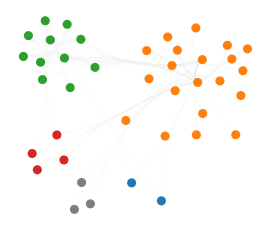

In [142]:
## display community detection outputs sample: from https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

# create a modular graph
"""partition_sizes = [10, 20, 30, 40]
g = nx.random_partition_graph(partition_sizes, 0.5, 0.1)

# since we created the graph, we know the best partition:
node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1

# # alternatively, we can infer the best partition using Louvain:
# from community import community_louvain"""
node_to_community = community_louvain.best_partition(G)

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4: 'tab:gray',
    5: 'tab:cyan'
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)
plt.show()

In [144]:
node_to_community

{'Stanford University': 0,
 'United States National Science Foundation (NSF)': 0,
 'United States National Institutes of Health (NIH)': 1,
 'Open Society Foundations': 1,
 'United States Centers for Disease Control and Prevention (CDC)': 2,
 'Doris Duke Charitable Foundation (DDCF)': 1,
 'National Institute of Justice': 2,
 'US Department of Housing and Urban Development': 2,
 'Chicago Community Trust': 2,
 'Owen L. Coon Foundation': 2,
 'MacArthur Foundation': 2,
 'William T. Grant Foundation': 2,
 'Office of Juvenile Justice and Delinquency Prevention, US Department of Justice': 2,
 'United States Department of Health and Human Services (HHS)': 2,
 'Robert Wood Johnson Foundation': 2,
 'US Department of Labor': 2,
 'UCSD Center for AIDS Research (CFAR) (International Pilot)': 1,
 'Innovation+Design Enabling Access Initiative at the Johns Hopkins Bloomberg School of Public Health': 1,
 'UK Research and Innovation (UKRI)': 1,
 'Laura and John Arnold Foundation': 4,
 'U.S. Cancer Pain R

In [169]:
## use community detection to add group information to the output dict's node item
"""for f in funders:
    for dim in ["WoS Categories","Research Areas"]:
        for s in funderSubjDict[f][dim]['subjects']:
            G = nx.Graph()
            elist = [(x["source"],x["target"],x["value"]) for x in funderSubjStats[f][dim][s]['links']]
            G.add_weighted_edges_from(elist)
            # use louvain algorithm to detect communities
            node_to_community = community_louvain.best_partition(G)
            funderSubjStats[f][dim][s]['nodes'] = [{"id":k,"group":v} for k,v in node_to_community.items()]

            """

'for f in funders:\n    for dim in ["WoS Categories","Research Areas"]:\n        for s in funderSubjDict[f][dim][\'subjects\']:\n            G = nx.Graph()\n            elist = [(x["source"],x["target"],x["value"]) for x in funderSubjStats[f][dim][s][\'links\']]\n            G.add_weighted_edges_from(elist)\n            # use louvain algorithm to detect communities\n            node_to_community = community_louvain.best_partition(G)\n            funderSubjStats[f][dim][s][\'nodes\'] = [{"id":k,"group":v} for k,v in node_to_community.items()]\n\n            '

In [148]:
funderSubjStats["osf"]

{'WoS Categories': {'Medicine, General & Internal': {'top_cofunders': [{'funder': 'Open Society Foundations',
     'value': 86},
    {'funder': 'United States National Institutes of Health (NIH)',
     'value': 21},
    {'funder': 'UK Research and Innovation (UKRI)', 'value': 6},
    {'funder': 'Livestrong Foundation', 'value': 6},
    {'funder': 'Laura and John Arnold Foundation', 'value': 5},
    {'funder': 'United States Agency for International Development (USAID)',
     'value': 4},
    {'funder': 'Atlantic Philanthropies', 'value': 4},
    {'funder': 'Engelberg Foundation', 'value': 4},
    {'funder': 'United States Centers for Disease Control and Prevention (CDC)',
     'value': 3},
    {'funder': 'Harvard-MIT Center for Regulatory Science', 'value': 3},
    {'funder': 'United States Cancer Pain Relief Committee', 'value': 3},
    {'funder': 'United Nations Population Fund', 'value': 3},
    {'funder': 'Bill and Melinda Gates Foundation', 'value': 3},
    {'funder': 'South Afric

In [175]:
## quick check on how many community partitions are typically present...
for f in funders:
    community_nos = []
    for dim in ["WoS Categories","Research Areas"]:
        for s in funderSubjDict[f][dim]['subjects']:
            communities = [x['group'] for x in funderSubjStats[f][dim][s]['nodes']]
            community_nos.append(len(list(set(communities))))
    print(f,": ",Counter(community_nos))

rwj :  Counter({3: 10, 5: 10, 2: 8, 7: 8, 4: 7, 6: 5, 9: 2})
gates :  Counter({5: 18, 4: 15, 3: 7, 6: 5, 2: 4, 7: 1})
packard :  Counter({4: 17, 5: 13, 3: 7, 6: 6, 2: 4, 7: 2, 8: 1})
osf :  Counter({4: 20, 5: 12, 6: 9, 3: 3, 2: 3, 9: 1, 8: 1, 7: 1})
hewlett :  Counter({4: 17, 5: 13, 6: 9, 3: 7, 7: 3, 9: 1})
mellon :  Counter({6: 15, 5: 12, 4: 12, 2: 6, 3: 4, 8: 1})
ford :  Counter({5: 12, 6: 11, 7: 8, 3: 7, 4: 7, 2: 2, 8: 2, 10: 1})


## Ouput analytics assets

In [230]:
import pickle

In [275]:
pickle.dump( funderSubjStats, open( "funderSubjStats.p", "wb" ) )

In [276]:
with open('funderSubjStats.json', 'w') as outfile:
    json.dump(funderSubjStats, outfile)

In [277]:
## create separate files:
for f in funders:
    for dim in ["WoS Categories","Research Areas"]:
        with open("funder_subj_stats/"+f+"_"+dim+".json","w") as outfile:
            json.dump(funderSubjStats[f][dim],outfile)

## TO DO

In [ ]:
## num with grant numbers for each subject/funder and also at the broader funder aggregate level
## num funders in the cofunder list across grants for subject/funder and also at the broader level